# Am I the Asshole (AITA) Prediction

The purpose of this project is to 1) find the features most likely to predict who the crowd determines is an asshole, and 2) predict who is in fact an asshole. The data comes from Reddit's AITA subreddit (www.reddit.com/r/AITA).

The data, mostly cleaned here, https://github.com/iterative/aita_dataset/blob/master/aita_clean.csv.dvc, includes the most essential features below. I have added a series of features based on hypotheses, also described below, attempting to discern what is an effective way to guess at assholery. Exploratory data analysis is used to derive relationships between You're The Asshole and Not The Asshole (categorical variable) and the various parameters examined.

All observations are threads (title and body). No information about the poster other than what is in the body is known.

It is more than likely that some people have posted more than once, about different situations; it's fair to say that the number of observations is representative of the number of situations asked about, and not representative of how many people are asking for help from the community (the latter of which we have no number for).

# Data Fields

- id: The unique post ID
- timestamp: The timestamp of the post in datetime (originally in epoch time)
- title: The subject line of the post
- body: The full body of the post
- edited: Whether it was edited or not (T/F)
- verdict: The community's decision ("You're the Asshole" and "Everyone Sucks" both count as being an asshole)
- score: The number of "upvotes" the community gave to that post (roughly, how much interest the community had in that post)
- num_comments: How many people commented on the post
- is_asshole: 1 for yes, 0 for no

# Importing the Data

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np
import datetime

#misc
import gc
import os
import time
import warnings

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans

#textstat
import textstat


#settings
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline


C:\Users\Robert Malka\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r"C:\Users\Robert Malka\Desktop\aita_clean_3.2.csv")

# Exploring the Data

In [3]:
df.head()

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
0,1ytxov,2014-02-24 21:50:51,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1
1,1yu29c,2014-02-24 22:33:04,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",True,asshole,140,27.0,1
2,1yu8hi,2014-02-24 23:31:17,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0
3,1yuc78,2014-02-25 00:05:28,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,True,everyone sucks,22,3.0,1
4,1yueqb,2014-02-25 00:29:24,[AITA] I let my story get a little long and bo...,NaN,False,not the asshole,6,4.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97628 entries, 0 to 97627
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            97628 non-null  object 
 1   timestamp     97628 non-null  object 
 2   title         97628 non-null  object 
 3   body          97541 non-null  object 
 4   edited        97628 non-null  bool   
 5   verdict       97628 non-null  object 
 6   score         97628 non-null  int64  
 7   num_comments  97628 non-null  float64
 8   is_asshole    97628 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(5)
memory usage: 6.1+ MB


In [5]:
df.dtypes

id               object
timestamp        object
title            object
body             object
edited             bool
verdict          object
score             int64
num_comments    float64
is_asshole        int64
dtype: object

Verifying that there are no typos or missing variables in the data...

In [6]:
#Checking to see if there are any NaN values in e.g. cell 5 of column body. None, which is great.

df['body'].values[5:6]

array(['I love the musical *Les Miserables*. A coworker of mine said that they didn\'t like it. I asked why and they said, among other things, that "it\'s not a musical, it\'s an opera."\n\nNow, I happen to be an opera singer. I told them adamantly that it is NOT an opera. There are a number of things that make this true, but if you can take my word for it- and I hope you can- it\'s not a matter of opinion whether a mainstream musical is an opera or not. It is a musical, period.\n\nMy coworker thought otherwise. "My boyfriend writes musicals and he agrees with me" was the extent of her argument. Well, he may well write musicals but that doesn\'t mean he knows anything about opera. You might as well ask a jazz pianist to tell you about Beethoven- it\'s not the same area of expertise even if it\'s related. I told her "You\'re entitled to your opinion even if it\'s wrong" in a sort-of joking way. Maybe I was being dickish.\n\nI gotta know- am I the asshole?'],
      dtype=object)

In [7]:
df = df.dropna()

In [8]:
#Function that calculates percentage of missing data per column.
#subheading, e.g. filling missing data.

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

               column_name  percent_missing
id                      id              0.0
timestamp        timestamp              0.0
title                title              0.0
body                  body              0.0
edited              edited              0.0
verdict            verdict              0.0
score                score              0.0
num_comments  num_comments              0.0
is_asshole      is_asshole              0.0


# Hypotheses & Visualizations

## Histogram of is_asshole

### So we know what we're looking at...

Text(0.5, 1.0, 'How many Assholes there are on the AITA subreddit')

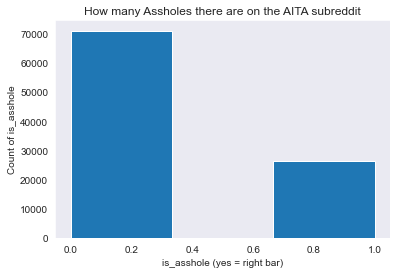

In [9]:
#Categories are '0' and '1'

plt.hist(df['is_asshole'], bins=3);
plt.xlabel('is_asshole (yes = right bar)')
plt.ylabel('Count of is_asshole')
plt.title('How many Assholes there are on the AITA subreddit')

Interesting! So most of the time, people are NOT considered assholes ('0' (the left side) are not deemed assholes) -- it's actually only about 25,000 of 97,000 people -- or a little more than 25% -- of people who are deemed an asshole in the first place.

# Features

I'm opting to examine some core features of the Title and the Body. They can be described as the following:

- countI: How many times I is said in the body of the text. (Does number of "I"s correlate with narcissism/being an asshole?)
- countHeSheThey: How many times He/She/They is said in the body of the text. (Does number of times OP (original poster) mentions others correlate in either direction to being an asshole (being thoughtful, or placing blame on others)?
- IvsHeSheThey: countI divided by countHeSheThey. Does any proportion between these two numbers suggest being/not being an asshole?
- post_word_count: The length of the post.
- questionmarklast: Whether or not the post ends in a question mark (does asking versus saying, in this case, the last sentence, suggest a humility or arrogance?).
- WIBTA_AITA: Whether the title asks "Would I be the asshole", versus "Am I the asshole" -- are there any differences in decision based on choosing one or the other?
- bodyreadinglevel: Estimating the reading level of the body text.

In [10]:
df['countI'] = df.body.str.count("I|I'm")


In [11]:
df['countHeSheThey'] = df.body.str.count("[Tt]hey|[Hh]e|[Ss]he")


In [12]:
df['IvsHeSheThey'] = df.body.str.count("I|I'm") / df.body.str.count("they|he|she")
df['IvsHeSheThey'] = np.where(df.IvsHeSheThey.isin([np.inf, -np.inf]), df['countI'], df['IvsHeSheThey'])


#Have to check out if the lowest and highest fractions correlate at all with assholery. Will look at the 
#distribution and see the points. It's continuous so we should be able to see some interesting outliers.

In [13]:
df = df[df['body'].notnull()]

df['post_word_count'] = [len(item.split()) for item in df['body'].values]

In [14]:
df['questionmarklast'] = df.body.str.endswith('?')

df["questionmarklast"] = df["questionmarklast"].astype(int)

In [15]:
def aita(string):
    if ("wibta" in string.lower()) or ("would i be the asshole" in string.lower()):
        return "WIBTA"
    elif ("aita" in string.lower()) or ("am i the asshole" in string.lower()):
        return "AITA"
    else:
        return "Neither"

df['WIBTA_AITA'] = df.title.apply(aita)

In [16]:
df['bodyreadinglevel'] = df['body'].apply(lambda x: textstat.flesch_kincaid_grade(x))

In [17]:
print(df['bodyreadinglevel'])

0         13.8
1          5.8
2         -2.7
3        179.9
5          6.8
         ...  
97623      7.9
97624     10.6
97625     12.7
97626     10.2
97627     15.1
Name: bodyreadinglevel, Length: 97541, dtype: float64


Notice there's at least one negative reading level. (Row 2: -2.7.) This suggests the post was confusing. (Note that the post was designated 'not the asshole.') Post in full is:

*Title:* I told a goth girl she looked like a clown.
*Body:* I was four.

So we see immediately that not only is it not "confusing", but remarkably clear, in context. (When title and body are included, the reading level becomes a slightly-improved -1.4.):

In [18]:
post_2 = ("I told a goth girl she looked like a clown. I was four.")

print_post = (textstat.flesch_kincaid_grade(post_2))

print(print_post)

-1.4


The negative reading level is indicative of a more metaphysically-systemic issue: it's revealing of the limits of meaning that can be derived from system that is not embodied. (Philosopher Hubert Dreyfus calls it the lack of "embodied cognition.") More on this in the final report. The short answer: There is *no way* for AI, as currently designed, to understand the context required behind, in this example, the archetype most people hold for "a goth girl," and all of the nuanced qualities a goth girl has; the quality of the insult "clown" and how it fits (or doesn't) with being a goth; the fact that it *is taken as an insult* or presumed to be taken as an insult; and how a human being can broadly come to understand and value (or not) the remark as it's made by a four-year-old. There is nothing reducible to "data-crunching" in each of these pieces.

In this particular thread, we can imagine a multitude of responses by the goth girl: laughter, maybe, or, if she felt insecure, perhaps she *was,* in some indirect way, insulted; but the response of the community intuitively seems to been grounded in a certain (and not unchangeable) cultural understanding, that a kid's innocence excuses him from what might otherwise be a rude or crass remark. Note that none of the reasonable inferences I've made are visible in the post itself. To get it, one would have to be a human being familiar with American culture - which is not reducible to any atomic elements, but an entire ecosystem with an interplay of nearly infinite parts, to which we have access.

One final note: It is not about *having* the information, but about understanding how that information interacts with itself, and how (particularly people, but also animals) interact with it. Machine learning brute-forces certain inferences and assessments by way of collecting massive amounts of data, but there is as yet no means to access, except "from the outside," as it were, how we take, create, value, and work with what we receive in the world. In order for an AI to really, really understand what is meant by a chair, it must be able to see something as valuable for sitting. This is a cultural conception, and not an innate property of the chair. All this and more to be continued.

In any case:

Checking to see if there are any missing values before we go on:

In [19]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

print(missing_value_df)

                       column_name  percent_missing
id                              id         0.000000
timestamp                timestamp         0.000000
title                        title         0.000000
body                          body         0.000000
edited                      edited         0.000000
verdict                    verdict         0.000000
score                        score         0.000000
num_comments          num_comments         0.000000
is_asshole              is_asshole         0.000000
countI                      countI         0.000000
countHeSheThey      countHeSheThey         0.000000
IvsHeSheThey          IvsHeSheThey         0.097395
post_word_count    post_word_count         0.000000
questionmarklast  questionmarklast         0.000000
WIBTA_AITA              WIBTA_AITA         0.000000
bodyreadinglevel  bodyreadinglevel         0.000000


There are, in IvsHeSheThey - let's fix them...

In [20]:
df['IvsHeSheThey'] = df['IvsHeSheThey'].fillna(value=0)


percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

print(missing_value_df)

                       column_name  percent_missing
id                              id              0.0
timestamp                timestamp              0.0
title                        title              0.0
body                          body              0.0
edited                      edited              0.0
verdict                    verdict              0.0
score                        score              0.0
num_comments          num_comments              0.0
is_asshole              is_asshole              0.0
countI                      countI              0.0
countHeSheThey      countHeSheThey              0.0
IvsHeSheThey          IvsHeSheThey              0.0
post_word_count    post_word_count              0.0
questionmarklast  questionmarklast              0.0
WIBTA_AITA              WIBTA_AITA              0.0
bodyreadinglevel  bodyreadinglevel              0.0


In [21]:
df.describe()

,score,num_comments,is_asshole,countI,countHeSheThey,IvsHeSheThey,post_word_count,questionmarklast,bodyreadinglevel
count,97541.000000,97541.000000,97541.000000,97541.000000,97541.000000,97541.000000,97541.000000,97541.000000,97541.000000
mean,324.838099,85.332168,0.271383,18.017921,33.978348,0.651182,337.229575,0.453307,15.222347
std,1965.611905,312.535658,0.444676,11.427630,21.317624,0.461958,183.968386,0.497818,22.804804
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.700000
25%,5.000000,14.000000,0.000000,10.000000,19.000000,0.387755,203.000000,0.000000,7.700000
50%,10.000000,23.000000,0.000000,16.000000,30.000000,0.565217,309.000000,0.000000,10.000000
75%,37.000000,46.000000,1.000000,24.000000,45.000000,0.800000,452.000000,1.000000,13.500000
max,59187.000000,11906.000000,1.000000,286.000000,689.000000,18.000000,5507.000000,1.000000,839.400000


## Histograms of certain basic features


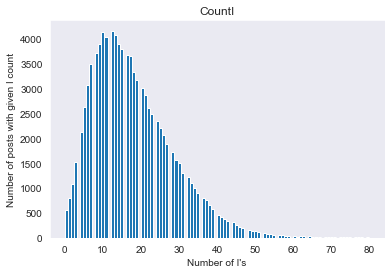

In [22]:
plt.hist(df['countI'], bins=100, range=(0, 80));
plt.xlabel('Number of I\'s')
plt.ylabel('Number of posts with given I count')
plt.title('CountI')
plt.show()

So we see that the number of I's very rarely go past ~10-20 per post. In Hypothesis Two we'll take a look at whether or not some of the extremes are correlated with increased post count, and if they're not, whether or not the outliers indicate anything about being an asshole.
   

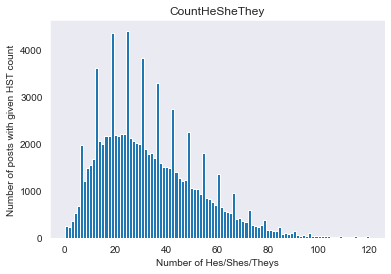

In [23]:
plt.hist(df['countHeSheThey'], bins=100, range=(0, 120));
plt.xlabel('Number of Hes/Shes/Theys')
plt.ylabel('Number of posts with given HST count')
plt.title('CountHeSheThey')
plt.show()

Notice the occasional jumps -- there are a few numbers of Hes/Shes/Theys that, combined, are extraordinarily common for posts, hence why many of the bars jump out far past the skewed curve.

We'll also look at whether or not the outliers indicate increased or decreased assholery.

Text(0.5, 1.0, 'Post Word Count')

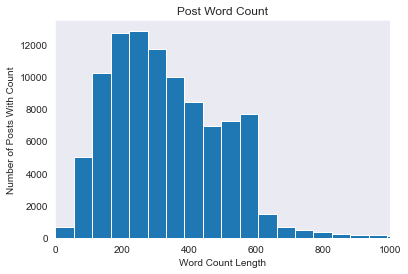

In [24]:
plt.hist(df['post_word_count'], bins=100)
plt.xlim(0, 1000)
plt.xlabel('Word Count Length')
plt.ylabel('Number of Posts With Count')
plt.title('Post Word Count')

Text(0.5, 1.0, 'Reading Level')

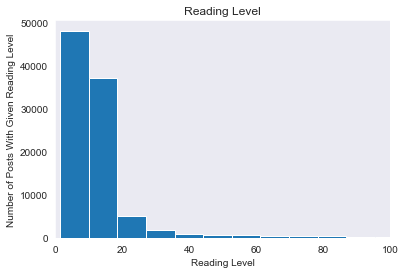

In [25]:
plt.hist(df['bodyreadinglevel'], bins=100)
plt.xlim(0, 100)
plt.xlabel('Reading Level')
plt.ylabel('Number of Posts With Given Reading Level')
plt.title('Reading Level')

#Let's get a zoomed in look at two parts of this graph, the skewed left side and the more subtle right side:

Text(0.5, 1.0, 'Reading Level, High End')

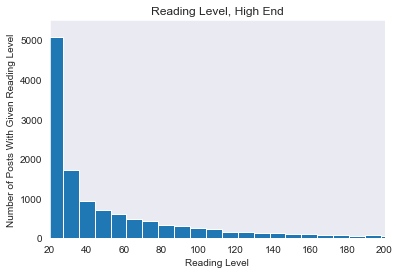

In [26]:
plt.hist(df['bodyreadinglevel'], bins=100)
plt.xlim(20, 200)
plt.ylim(0, 5500)
plt.xlabel('Reading Level')
plt.ylabel('Number of Posts With Given Reading Level')
plt.title('Reading Level, High End')

#So we see that the far side actually has some insanely high reading levels. We'll look into that in hypothesis
#two.

Text(0.5, 1.0, 'Reading Level, Low End')

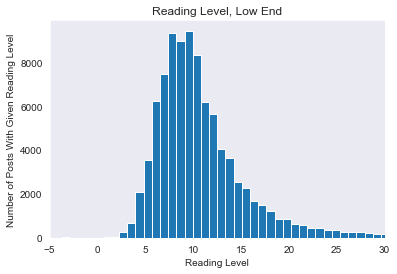

In [27]:
plt.hist(df['bodyreadinglevel'], bins=1000)
plt.xlim(-5, 30)
plt.xlabel('Reading Level')
plt.ylabel('Number of Posts With Given Reading Level')
plt.title('Reading Level, Low End')

#and the skewed left side actually reveals that most are in the ~5-12 reading level. Almost none are negative.

# Cramers V + Heatmap

Performing a Cramer's V test to examine the correlation between categorical variables. This is preferable to a heatmap w/r/t categorical variables, but we'll do both to see how substantial the difference is.


In [28]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [29]:
cramers_list = [df['edited'],
                df['countI'], 
                df['countHeSheThey'], 
                df['IvsHeSheThey'], 
                df['post_word_count'], 
                df['questionmarklast'], 
                df['WIBTA_AITA'],
                df['bodyreadinglevel']
               ]

list_cramers_names = ['edited', 'countI', 'countHeSheThey', 'IvsHeSheThey', 'post_word_count', 'questionmarklast', 
                      'WIBTA_AITA', 'bodyreadinglevel']

In [30]:
for col in list_cramers_names:
    print("The Cramers V value of {} over is_asshole is {}".format(col, cramers_v(df[col], df['is_asshole'])))

The Cramers V value of edited over is_asshole is 0.09484269395353913
The Cramers V value of countI over is_asshole is 0.034829556030657856
The Cramers V value of countHeSheThey over is_asshole is 0.03005672289409666
The Cramers V value of IvsHeSheThey over is_asshole is 0.0
The Cramers V value of post_word_count over is_asshole is 0.053900686412055226
The Cramers V value of questionmarklast over is_asshole is 0.04587681872399618
The Cramers V value of WIBTA_AITA over is_asshole is 0.021922342926157464
The Cramers V value of bodyreadinglevel over is_asshole is 0.02116776853978297


Interesting! So while the correlation for virtually all of them is pretty low, it's interesting to note that whether or not the OP edited their post is correlated with an increased likelihood of being an asshole. Just to be thorough, we see something similar with the heatmap:

In [31]:
#Calculate the correlation coefficients
corr = df.corr(method='pearson', min_periods=1) 
#plot it in the next line
corr.round(2).style.background_gradient(cmap='coolwarm')

,edited,score,num_comments,is_asshole,countI,countHeSheThey,IvsHeSheThey,post_word_count,questionmarklast,bodyreadinglevel
edited,1.000000,0.070000,0.100000,0.090000,0.140000,0.120000,-0.000000,0.150000,-0.380000,0.000000
score,0.070000,1.000000,0.840000,-0.010000,0.050000,0.060000,-0.020000,0.060000,-0.030000,-0.000000
num_comments,0.100000,0.840000,1.000000,0.040000,0.060000,0.060000,-0.010000,0.070000,-0.030000,-0.000000
is_asshole,0.090000,-0.010000,0.040000,1.000000,-0.020000,-0.020000,-0.000000,-0.030000,-0.050000,-0.010000
countI,0.140000,0.050000,0.060000,-0.020000,1.000000,0.640000,0.200000,0.800000,-0.070000,-0.020000
countHeSheThey,0.120000,0.060000,0.060000,-0.020000,0.640000,1.000000,-0.350000,0.900000,-0.060000,0.060000
IvsHeSheThey,-0.000000,-0.020000,-0.010000,-0.000000,0.200000,-0.350000,1.000000,-0.150000,-0.000000,-0.080000
post_word_count,0.150000,0.060000,0.070000,-0.030000,0.800000,0.900000,-0.150000,1.000000,-0.080000,0.070000
questionmarklast,-0.380000,-0.030000,-0.030000,-0.050000,-0.070000,-0.060000,-0.000000,-0.080000,1.000000,-0.010000
bodyreadinglevel,0.000000,-0.000000,-0.000000,-0.010000,-0.020000,0.060000,-0.080000,0.070000,-0.010000,1.000000


Next, we'll systematically go through some hypotheses, looking at the data in the following ways:

- Boxplot and/or Barplot, where applicable
- Get the mean of any feature relative to its likelihood of hypothesizing is_asshole
- Break down any distributions into the upper and lower quintiles
- Run a t-test on the upper and lower quintiles

## Hypothesis One

  1) How many times we see "I" in a post as correlated with the judgment of YTA/NTA.
  1a) Contrast that with number of times we see "they, she, he" in the same posts.  
  
  - The null is: The number of I's doesn't reflect whether someone is an asshole or not.

- If we reject the Null, I'm curious to see if either of the following could be inferred: 
 
   1) The greater the number of I's relative to other pronouns, the more likely a person will be considered an 
   Asshole. 
        - That frequency of self-reference correlates with self-centeredness, which means increased assholery.
   2) The fewer the number of I's relative to other pronouns, the less likely a person will be considered an 
   Asshole.
        - That rarity of self-references correlates with consideration of others, which means decreased assholery.

First up, CountI:

Text(0.5, 1.0, 'CountI')

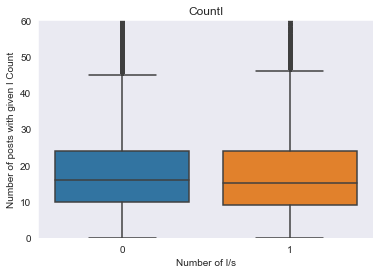

In [32]:
#No significant difference observed in count of I's vs assholery, as also suggested by our Cramers V review.

ax2 = sns.boxplot(x="is_asshole", y="countI", data=df)
plt.ylim(0,60)
plt.xlabel('Number of I/s')
plt.ylabel('Number of posts with given I Count')
plt.title('CountI')

In [33]:
CI_quantilelow = df['countI'].quantile(q=0.2)
CI_quantilehigh = df['countI'].quantile(q=0.8)

df['countI_highQ'] = df['countI'].apply(lambda x: x > CI_quantilehigh)
df['countI_lowQ'] = df['countI'].apply(lambda x: x > CI_quantilelow)

In [34]:
#First variable is -yes- asshole, second variable is -no- asshole

CIHi_mean1, CIHi_mean2 = df.groupby('countI_highQ')['is_asshole'].mean()
CILo_mean1, CILo_mean2 = df.groupby('countI_lowQ')['is_asshole'].mean()

In [35]:
print(CIHi_mean1, CIHi_mean2)
print(CILo_mean1, CILo_mean2)

#Assholery remains roughly the same globally (though the fact that the low quintile has the HIGHEST affirmed
#rate of being an asshole is interesting.
#Let's see how things look for the T-Test.

0.27507265589150054 0.2562208601812562
0.2905900837988827 0.26548660708303745


In [36]:
from scipy.stats import ttest_ind

CI_HQ_isasshole = df.loc[df.is_asshole == 1, 'countI_highQ']
CI_HQ_notasshole = df.loc[df.is_asshole == 0, 'countI_highQ']

CI_LQ_isasshole = df.loc[df.is_asshole == 1, 'countI_lowQ']
CI_LQ_notasshole = df.loc[df.is_asshole == 0, 'countI_lowQ']


In [37]:
print(ttest_ind(CI_HQ_isasshole, CI_HQ_notasshole))

print(ttest_ind(CI_LQ_isasshole, CI_LQ_notasshole))

#very significant findings -

Ttest_indResult(statistic=-5.253740060194786, pvalue=1.4935328659451507e-07)
Ttest_indResult(statistic=-7.476604606741018, pvalue=7.690233784609942e-14)


Next up is CountHeSheThey:

Text(0.5, 1.0, 'CountHeSheThey')

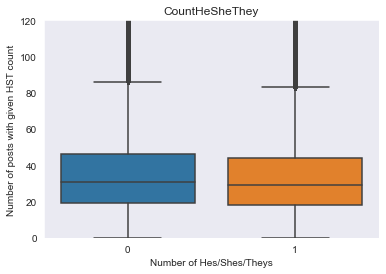

In [38]:
#No significant difference observed in count of HeSheThey vs assholery, as also suggested by our Cramers V review.

ax2 = sns.boxplot(x="is_asshole", y="countHeSheThey", data=df)
plt.ylim(0,120)
plt.xlabel('Number of Hes/Shes/Theys')
plt.ylabel('Number of posts with given HST count')
plt.title('CountHeSheThey')

In [39]:
HST_quantilelow = df['countHeSheThey'].quantile(q=0.2)
HST_quantilehigh = df['countHeSheThey'].quantile(q=0.8)

df['countHeSheThey_highQ'] = df['countHeSheThey'].apply(lambda x: x > HST_quantilehigh)
df['countHeSheThey_lowQ'] = df['countHeSheThey'].apply(lambda x: x > HST_quantilelow)

In [40]:
#First variable is -yes- asshole, second variable is -no- asshole

HSTHi_mean1, HSTHi_mean2 = df.groupby('countHeSheThey_highQ')['is_asshole'].mean()
HSTLo_mean1, HSTLo_mean2 = df.groupby('countHeSheThey_lowQ')['is_asshole'].mean()

In [41]:
print(HSTHi_mean1, HSTHi_mean2)
print(HSTLo_mean1, HSTLo_mean2)

#Assholery remains roughly the same globally.
#so we have to see how things look for the T-Test.

0.2750807013102095 0.2556346381969158
0.28419237012987014 0.2681391255187655


In [42]:
HST_HQ_isasshole = df.loc[df.is_asshole == 1, 'countHeSheThey_highQ']
HST_HQ_notasshole = df.loc[df.is_asshole == 0, 'countHeSheThey_highQ']

HST_LQ_isasshole = df.loc[df.is_asshole == 1, 'countHeSheThey_lowQ']
HST_LQ_notasshole = df.loc[df.is_asshole == 0, 'countHeSheThey_lowQ']


In [43]:
print(ttest_ind(HST_HQ_isasshole, HST_HQ_notasshole))

print(ttest_ind(HST_LQ_isasshole, HST_LQ_notasshole))

#Significant, and the numbers deviate moderately (up to 3%) from the global mean of is_asshole. Let's move on.

Ttest_indResult(statistic=-5.360204920439671, pvalue=8.331574365066229e-08)
Ttest_indResult(statistic=-4.527988872331087, pvalue=5.961805558631947e-06)


Finally, let's look at IvsHeSheThey, and see what difference the proportion between them makes....

Text(0.5, 1.0, 'IvsHeSheThey')

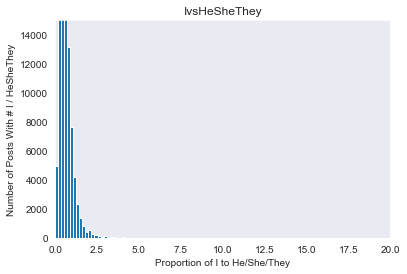

In [44]:
plt.hist(df['IvsHeSheThey'], bins=100)
plt.xlim(0, 20)
plt.ylim(0, 15000)
plt.xlabel('Proportion of I to He/She/They')
plt.ylabel('Number of Posts With # I / HeSheThey')
plt.title('IvsHeSheThey')

#the vast, vast majority of proportions are near 0 (<1 count of I for 1 count of He/She/They).

In [45]:
IvsH_quantilelow = df['IvsHeSheThey'].quantile(q=0.2)
IvsH_quantilehigh = df['IvsHeSheThey'].quantile(q=0.8)

df['IvsHeSheThey_highQ'] = df['IvsHeSheThey'].apply(lambda x: x > IvsH_quantilehigh)
df['IvsHeSheThey_lowQ'] = df['IvsHeSheThey'].apply(lambda x: x > IvsH_quantilelow)

In [46]:
#First variable is -yes- asshole, second variable is -no- asshole

IvsHHi_mean1, IvsHHi_mean2 = df.groupby('IvsHeSheThey_highQ')['is_asshole'].mean()
IvsHLo_mean1, IvsHLo_mean2 = df.groupby('IvsHeSheThey_lowQ')['is_asshole'].mean()

In [47]:
print(IvsHHi_mean1, IvsHHi_mean2)
print(IvsHLo_mean1, IvsHLo_mean2)

#Assholery remains roughly the same globally.
#so we have to see how things look for the T-Test.

0.2727726255196674 0.2657750697098007
0.26736852812531786 0.27239692343250427


In [48]:
IvsH_HQ_isasshole = df.loc[df.is_asshole == 1, 'IvsHeSheThey_highQ']
IvsH_HQ_notasshole = df.loc[df.is_asshole == 0, 'IvsHeSheThey_highQ']

IvsH_LQ_isasshole = df.loc[df.is_asshole == 1, 'IvsHeSheThey_lowQ']
IvsH_LQ_notasshole = df.loc[df.is_asshole == 0, 'IvsHeSheThey_lowQ']


In [49]:
print(ttest_ind(IvsH_HQ_isasshole, IvsH_HQ_notasshole))

print(ttest_ind(IvsH_LQ_isasshole, IvsH_LQ_notasshole))

#Not significant, and the quintile means aren't big jumps either.

Ttest_indResult(statistic=-1.960512673026989, pvalue=0.049938740130975844)
Ttest_indResult(statistic=1.4168332103383967, pvalue=0.1565348912979041)


## Hypothesis Two

2) Length of post relative to YTA/NTA (which might tell us how much justification a person applied to their situation, or how invested they are.

 - The Null is: The word count does not reflect whether someone is regarded as an asshole.

Possible Hypotheses if the Null is rejected: 

    1) Level of thoughtfulness committed to a situation (positive); 
    2) Level of self-rationalization about a situation (negative). 
    
We will also be looking at the reading level here, and seeing if there are any indicators of assholery.
     

Text(0.5, 1.0, 'Post Word Count')

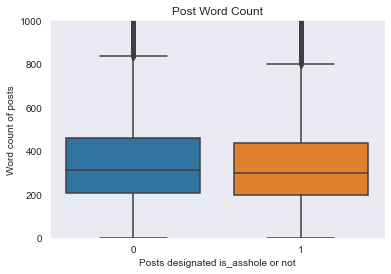

In [50]:
ax4 = sns.boxplot(x="is_asshole", y="post_word_count", data=df)
plt.ylim(0,1000)
plt.xlabel('Posts designated is_asshole or not')
plt.ylabel('Word count of posts')
plt.title('Post Word Count')

There is a very slight observable difference in median length and not being an asshole - but this may turn out not to be useful.

Intuitively, one suspects that, if there *is* any genuine relationship here, it'd be the first resultant hypothesis - that the person is more thoughtful about their situation, having explained more and considered the nuances of it more seriously. 

It could also be that longer posts mean more nuance is given to the audience, who, with more information, are more likely to see the gray area (which leans them towards 'no' rather than 'yes.')

In [51]:
PWC_quantilelow = df['post_word_count'].quantile(q=0.2)
PWC_quantilehigh = df['post_word_count'].quantile(q=0.8)

df['post_word_count_highQ'] = df['post_word_count'].apply(lambda x: x > PWC_quantilehigh)
df['post_word_count_lowQ'] = df['post_word_count'].apply(lambda x: x > PWC_quantilelow)

In [52]:
#First variable is -yes- asshole, second variable is -no- asshole

PWCHi_mean1, PWCHi_mean2 = df.groupby('post_word_count_highQ')['is_asshole'].mean()
PWCLo_mean1, PWCLo_mean2 = df.groupby('post_word_count_lowQ')['is_asshole'].mean()

In [53]:
print(PWCHi_mean1, PWCHi_mean2)
print(PWCLo_mean1, PWCLo_mean2)

#Assholery remains roughly the same globally.
#so we have to see how things look for the T-Test.

0.2765728625201649 0.2505273990223823
0.29451566951566954 0.26554535533157864


In [54]:
PWC_HQ_isasshole = df.loc[df.is_asshole == 1, 'post_word_count_highQ']
PWC_HQ_notasshole = df.loc[df.is_asshole == 0, 'post_word_count_highQ']

PWC_LQ_isasshole = df.loc[df.is_asshole == 1, 'post_word_count_lowQ']
PWC_LQ_notasshole = df.loc[df.is_asshole == 0, 'post_word_count_lowQ']


In [55]:
print(ttest_ind(PWC_HQ_isasshole, PWC_HQ_notasshole))

print(ttest_ind(PWC_LQ_isasshole, PWC_LQ_notasshole))

Ttest_indResult(statistic=-7.30880323759411, pvalue=2.715836622994335e-13)
Ttest_indResult(statistic=-8.164636635832393, pvalue=3.262062423913887e-16)


Interesting, so we see some high significance for both values, but the PWC_Lo is the more interesting one: You're a few percentage points more likely to be an asshole if your post word count is among the shortest. Less explanation means more assumptions, and depending on the situations, that might lead to some intuitive leaps that lead to asshole judgment. Might also be the case that, wanting to say less, one also means to hide or imply things they'd rather not say (things that aren't good).

Let's see if an increase in the number of "I"'s relative to post count suggests an increased tendency towards assholery.

In [56]:
df['IoverPostCount'] = df.countI / df.post_word_count

print("The mean of 'IoverPostCount' is", df['IoverPostCount'].mean(), ".")
print("The bottom quantile of 'IoverPostCount' is", df['IoverPostCount'].quantile(q=0.2), ".")
print("The top quantile of 'IoverPostCount' is", df['IoverPostCount'].quantile(q=0.8), ".")

The mean of 'IoverPostCount' is 0.054849911415924914 .
The bottom quantile of 'IoverPostCount' is 0.0379746835443038 .
The top quantile of 'IoverPostCount' is 0.07142857142857142 .


Text(0.5, 1.0, 'IoverPostCount')

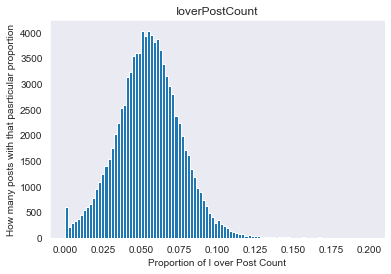

In [57]:
#Typical standard curve - cool

plt.hist(df['IoverPostCount'], bins=100, range=(0,0.2));
plt.xlabel('Proportion of I over Post Count')
plt.ylabel('How many posts with that pasrticular proportion')
plt.title('IoverPostCount')

Do the bottom and top quantiles of IoverPostCount lend themselves to percentages relative to is_asshole?

In [58]:
IoPC_quantilelow = df['IoverPostCount'].quantile(q=0.2)
IoPC_quantilehigh = df['IoverPostCount'].quantile(q=0.8)

df['IoverPostCount_highQ'] = df['IoverPostCount'].apply(lambda x: x > IoPC_quantilehigh)
df['IoverPostCount_lowQ'] = df['IoverPostCount'].apply(lambda x: x > IoPC_quantilelow)

In [59]:
IoPCH_mean1, IoPCH_mean2 = df.groupby('IoverPostCount_highQ')['is_asshole'].mean()
IoPCL_mean1, IoPCL_mean2 = df.groupby('IoverPostCount_lowQ')['is_asshole'].mean()

In [60]:
print(IoPCH_mean1, IoPCH_mean2)
print(IoPCL_mean1, IoPCL_mean2)

#The means for is_asshole remain basically at the global average - 
#so we have to see how things look for the T-Test.

0.2699887531312305 0.27703788153599007
0.2695927972171066 0.2718320874950316


In [61]:
IoPC_HQ_isasshole = df.loc[df.is_asshole == 1, 'IoverPostCount_highQ']
IoPC_HQ_notasshole = df.loc[df.is_asshole == 0, 'IoverPostCount_highQ']

IoPC_LQ_isasshole = df.loc[df.is_asshole == 1, 'IoverPostCount_lowQ']
IoPC_LQ_notasshole = df.loc[df.is_asshole == 0, 'IoverPostCount_lowQ']


In [62]:
print(ttest_ind(IoPC_HQ_isasshole, IoPC_HQ_notasshole))

print(ttest_ind(IoPC_LQ_isasshole, IoPC_LQ_notasshole))

#No signifcance indicated here, esp. as compared to our other features.

Ttest_indResult(statistic=1.9723106503205925, pvalue=0.04857697479407349)
Ttest_indResult(statistic=0.6295802166774608, pvalue=0.5289707451064446)


Finally, let's check out the body reading level:

In [63]:
BRL_quantilelow = df['bodyreadinglevel'].quantile(q=0.2)
BRL_quantilehigh = df['bodyreadinglevel'].quantile(q=0.8)

df['bodyreadinglevel_highQ'] = df['bodyreadinglevel'].apply(lambda x: x > BRL_quantilehigh)
df['bodyreadinglevel_lowQ'] = df['bodyreadinglevel'].apply(lambda x: x > BRL_quantilelow)

In [64]:
BRL_mean1, BRL_mean2 = df.groupby('bodyreadinglevel_highQ')['is_asshole'].mean()
BRL_mean1, BRL_mean2 = df.groupby('bodyreadinglevel_lowQ')['is_asshole'].mean()

In [65]:
print(BRL_mean1, BRL_mean2)
print(BRL_mean1, BRL_mean2)

#The means for is_asshole remain basically at the global average - 
#so we have to see how things look for the T-Test.

0.28425848807015824 0.26797614417217686
0.28425848807015824 0.26797614417217686


In [66]:
BRL_HQ_isasshole = df.loc[df.is_asshole == 1, 'bodyreadinglevel_highQ']
BRL_HQ_notasshole = df.loc[df.is_asshole == 0, 'bodyreadinglevel_highQ']

BRL_LQ_isasshole = df.loc[df.is_asshole == 1, 'bodyreadinglevel_lowQ']
BRL_LQ_notasshole = df.loc[df.is_asshole == 0, 'bodyreadinglevel_lowQ']


In [67]:
print(ttest_ind(BRL_HQ_isasshole, BRL_HQ_notasshole))

print(ttest_ind(BRL_LQ_isasshole, BRL_LQ_notasshole))
                
#once again, significant values, but the increases in is_asshole are moderate - 28% vs ~25%.
#(you are considered more likely to be an asshole at both the high and low ends.)

Ttest_indResult(statistic=-3.2742070573368545, pvalue=0.001059958270171628)
Ttest_indResult(statistic=-4.652321594191539, pvalue=3.2864879220906713e-06)



## Hypothesis Three

3) Whether or not the post ends with a question mark (asking for feedback from the crowd, versus making a statement of some kind. Of course it's possible that they didn't put the "?" down and were asking the question, but we presume the number of typos are insignificant).

  - The Null is: A question mark at the end of a post does not reflect whether someone is regarded as an asshole.

Hypothesis if the Null is rejected: 
    1) That asking a question perhaps shows an openness to being wrong (and thus suggests they're less likely to 
be an asshole), whereas making a statement (period or no punctuation) at the end of their evaluation shows a disregard for the crowd, leading to a greater possibility that they'll be evaluated as an asshole.

Text(0.5, 1.0, 'Questionmarklast')

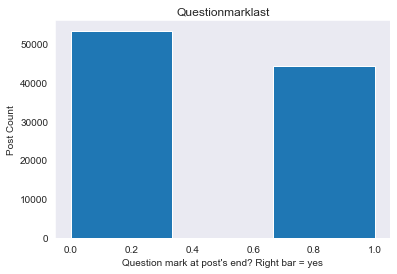

In [68]:
plt.hist(df['questionmarklast'], bins=3)
plt.xlabel('Question mark at post\'s end? Right bar = yes')
plt.ylabel('Post Count')
plt.title('Questionmarklast')

So more than half of all posts don't end in a question mark, where only 25% of threads are categorized as being an asshole.

Let's look at this through the lens of a barplot:

Text(0.5, 1.0, 'Question Mark at the end of a post: showing is_asshole or not?')

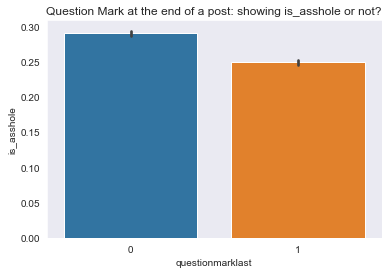

In [69]:
ax6=sns.barplot(x="questionmarklast", y="is_asshole", data=df)
plt.title('Question Mark at the end of a post: showing is_asshole or not?')

We see a significant difference in the barplot! People who ask a question at the end of their post (often "Am I the asshole?") are less likely to be judged an asshole. The correlation is interesting, but in no way conclusive.


In [70]:
QML_isasshole = df.loc[df.is_asshole == 1, 'questionmarklast']
QML_notasshole = df.loc[df.is_asshole == 0, 'questionmarklast']

In [71]:
print(ttest_ind(QML_isasshole, QML_notasshole))
                
#There we go! The difference of ~60% chance of not being called an asshole (no questionmark) vs the ~40% chance of 
#being called an asshole with a questionmark at the end is highly, highly significant.

Ttest_indResult(statistic=-14.385144843478738, pvalue=7.164914824518718e-47)


## Hypothesis Four

4) We're looking at the phrasing, "Would I be the asshole" vs "Am I the asshole?"

Null Hypothesis: There is no correlation between the hypothetical phrasing and the "actual" phrasing.

Should the null be rejected: The conditional might suggest a person who is more cautious, which means a person who is less likely to engage in assholery.

Let's look at a barchart where x-axis = AITA/WIBTA/neither & y-axis = is_asshole:


In [72]:
df[['WIBTA_AITA', 'is_asshole']].groupby('WIBTA_AITA').mean()

,is_asshole
WIBTA_AITA,
AITA,0.275955
Neither,0.235294
WIBTA,0.249823


Text(0, 0.5, 'Percentage of is_asshole posts fitting in these three categories')

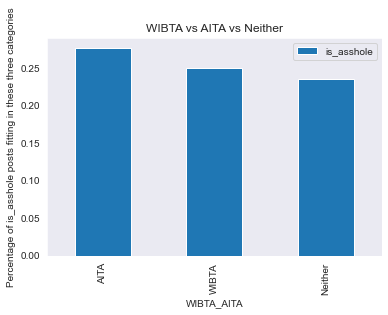

In [73]:
df[['WIBTA_AITA', 'is_asshole']].groupby('WIBTA_AITA').mean().sort_values(by='is_asshole', 
                                                                          ascending=False).plot(kind='bar')
plt.title("WIBTA vs AITA vs Neither")
plt.ylabel("Percentage of is_asshole posts fitting in these three categories")

Since you have a roughly 27% chance of being an asshole, it is noteworthy that WIBTA is 2 percentage points lower, and that someone who uses *neither* phrasing is a full 4 percentage points lower, at 23.5%.

## Hypothesis Five

Do we see a difference in likelihood of assholery based on whether or not a thread fits into the following categories? 

I suspect we'll see it as a higher likelihood in romantic relationships, and likely lower in professional concerns.

3) Categorizing data (through title) under four broad headings: 

  3a) Familial Disagreement 
    - "My Mom, Sister, Dad, Grandma, Grandpa, Grandparents, Brother, Cousin," &c
  3b) Professional Concerns 
    - "My Boss, My co-worker, My Colleague", &c.
  3c) Romantic Relationships
  	- Described using word embeddings: "My Boyfriend," "My Girlfriend," "My Partner," &c. 


In order to make this happen we'll do the following:
    - converting the subject line ("title") into a bag-of-words
    - vectorizing the individual words
    - applying a naive bayes model to it in a test-run, just to see how predictive individual words are with respect to assholery.

It cannot be emphasized enough (see final report): This has no correlation with the actual meaning and context these words have with their usage (it says nothing about why or what it means that these words are correlated with being an asshole - it only suggests that in these particular instances, in the context of this or that culture at this particular time, these words have a higher correlation with assholery.)

Let's look at another way to approach assholery, starting with family. We're going to investigate the titles and look for certain groupings -- in this case:

- Step-family; 
- God-family;
- Grandparents;
- Parents
- Siblings
- Kids
- Relatives

And see if they're more likely to involve asshole situations relative to the is_asshole average.


In [74]:
family_words = ['godmother', 'stepbrother', 'stepmother', 'stepsister', 'stepfather', 'grandpa', 'grandfather', 
                'granddad', 'dad', 'mom', 'father', 'mother', 'son', 'daughter', 'niece', 'nephew', 'uncle', 
                'aunt', 'godfather', 'godparents', 'godson', 'goddaughter', 'godchild', 'sibling', 'cousin',
                'siblings', 'stepdad', 'grandmothers', 'grandfathers', 'mum', 'daddy', 'brothers', 'sisters',
                'child', 'kid', 'stepson', 'stepdaughter', 'daughters', 'sons', 'kids', 'nephews', 'mil', 'bil',
                'sil', 'brother-in-law', 'sister-in-law', 'mother-in-law', 'in-laws']

step_isasshole = df[df.title.str.contains('stepbrother|stepmother|stepfather|stepsister|stepdad')]['is_asshole'].mean()
god_isasshole = df[df.title.str.contains('godmother|godfather|godparents|godson|goddaughter|godchild')]['is_asshole'].mean()
grand_isasshole = df[df.title.str.contains('grandmother|grandfather|grandpa|grandma|granddad|grandmothers|grandfathers')]['is_asshole'].mean()
parents_isasshole = df[df.title.str.contains('dad|mom|mother|father|mum|daddy')]['is_asshole'].mean()
siblings_isasshole = df[df.title.str.contains('brother|sister|sibling|siblings|brothers|sisters')]['is_asshole'].mean()
kids_isasshole = df[df.title.str.contains('daughter|son|child|kid|stepson|stepdaughter|daughters|sons|kids')]['is_asshole'].mean()
relatives_isasshole = df[df.title.str.contains('niece|nephew|uncle|aunt|cousin|cousins|nephews')]['is_asshole'].mean()
inlaws_isasshole = df[df.title.str.contains('mil|bil|sil|brother-in-law|sister-in-law|brother in law|sister in law|mother-in-law|mother in law|in-laws|in laws')]['is_asshole'].mean()

step_count = df[df.title.str.contains('stepbrother|stepmother|stepfather|stepsister|stepdad')]['is_asshole'].count()
god_count = df[df.title.str.contains('godmother|godfather|godparents|godson|goddaughter|godchild')]['is_asshole'].count()
grand_count = df[df.title.str.contains('grandmother|grandfather|grandpa|grandma|granddad|grandmothers|grandfathers')]['is_asshole'].count()
parents_count = df[df.title.str.contains('dad|mom|mother|father|mum|daddy')]['is_asshole'].count()
siblings_count = df[df.title.str.contains('brother|sister|sibling|siblings|brothers|sisters')]['is_asshole'].count()
kids_count = df[df.title.str.contains('daughter|son|child|kid|stepson|stepdaughter|daughters|sons|kids')]['is_asshole'].count()
relatives_count = df[df.title.str.contains('niece|nephew|uncle|aunt|cousin|cousins|nephews')]['is_asshole'].count()
inlaws_count = df[df.title.str.contains('mil|bil|sil|brother-in-law|sister-in-law|brother in law|sister in law|mother-in-law|mother in law|in-laws|in laws')]['is_asshole'].count()


is_asshole_mean = df['is_asshole'].mean()


In [75]:

print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('stepfamily', step_isasshole, is_asshole_mean, step_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('godparents', god_isasshole, is_asshole_mean, god_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('grandparents', grand_isasshole, is_asshole_mean, grand_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('parents', parents_isasshole, is_asshole_mean, parents_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('siblings', siblings_isasshole, is_asshole_mean, siblings_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('kids', kids_isasshole, is_asshole_mean, kids_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('relatives', relatives_isasshole, is_asshole_mean, relatives_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('in-laws', inlaws_isasshole, is_asshole_mean, inlaws_count))


The likelihood the subject was an asshole if the issue concerned stepfamily is 0.188, versus the general average of 0.2713833157338965, with a sample size of 250.
The likelihood the subject was an asshole if the issue concerned godparents is 0.3333333333333333, versus the general average of 0.2713833157338965, with a sample size of 33.
The likelihood the subject was an asshole if the issue concerned grandparents is 0.1878589007383101, versus the general average of 0.2713833157338965, with a sample size of 1219.
The likelihood the subject was an asshole if the issue concerned parents is 0.192831473425383, versus the general average of 0.2713833157338965, with a sample size of 10574.
The likelihood the subject was an asshole if the issue concerned siblings is 0.25592911128485796, versus the general average of 0.2713833157338965, with a sample size of 7674.
The likelihood the subject was an asshole if the issue concerned kids is 0.3187810945273632, versus the general average of 0.27138331

Well there we go! The general rule seems to be:

The lower the age of the person you're dealing with, the higher a chance you have of being the asshole. And by extension:

The higher the age of the person concerned, the lower the chance you have of being an asshole relative to them.

Now let's make this a column and see how many of the posts are about family.

In [76]:
family_words = ['godmother', 'stepbrother', 'stepmother', 'stepsister', 'stepfather', 'grandpa', 'grandfather', 
                'granddad', 'dad', 'mom', 'father', 'mother', 'son', 'daughter', 'niece', 'nephew', 'uncle', 
                'aunt', 'godfather', 'godparents', 'godson', 'goddaughter', 'godchild', 'sibling', 'cousin',
                'siblings', 'stepdad', 'grandmothers', 'grandfathers', 'mum', 'daddy', 'brothers', 'sisters',
                'child', 'kid', 'stepson', 'stepdaughter', 'daughters', 'sons', 'kids', 'nephews', 'mil', 'bil',
                'sil', 'brother-in-law', 'sister-in-law', 'mother-in-law', 'in-laws']

def family(string):
    title_tokens = set([token.lower() for token in string.split()])
    common_tokens = len(title_tokens.intersection(family_words))

    if common_tokens > 0:
        return 1
    else:
        return 0
 

df.title.apply(family)

0        0
1        0
2        0
3        0
5        0
        ..
97623    0
97624    0
97625    0
97626    1
97627    0
Name: title, Length: 97541, dtype: int64

About one in eight! Is the count any different if we look at the body of the posts rather than the title?

In [77]:
step2_isasshole = df[df.body.str.contains('stepbrother|stepmother|stepfather|stepsister|stepdad')]['is_asshole'].mean()
god2_isasshole = df[df.body.str.contains('godmother|godfather|godparents|godson|goddaughter|godchild')]['is_asshole'].mean()
grand2_isasshole = df[df.body.str.contains('grandmother|grandfather|grandpa|grandma|granddad|grandmothers|grandfathers')]['is_asshole'].mean()
parents2_isasshole = df[df.body.str.contains('dad|mom|mother|father|mum|daddy')]['is_asshole'].mean()
siblings2_isasshole = df[df.body.str.contains('brother|sister|sibling|siblings|brothers|sisters')]['is_asshole'].mean()
kids2_isasshole = df[df.body.str.contains('daughter|son|child|kid|stepson|stepdaughter|daughters|sons|kids')]['is_asshole'].mean()
relatives2_isasshole = df[df.body.str.contains('niece|nephew|uncle|aunt|cousin|cousins|nephews')]['is_asshole'].mean()
inlaws2_isasshole = df[df.body.str.contains('mil|bil|sil|brother-in-law|sister-in-law|brother in law|sister in law|mother-in-law|mother in law|in-laws|in laws')]['is_asshole'].mean()

step2_count = df[df.body.str.contains('stepbrother|stepmother|stepfather|stepsister|stepdad')]['is_asshole'].count()
god2_count = df[df.body.str.contains('godmother|godfather|godparents|godson|goddaughter|godchild')]['is_asshole'].count()
grand2_count = df[df.body.str.contains('grandmother|grandfather|grandpa|grandma|granddad|grandmothers|grandfathers')]['is_asshole'].count()
parents2_count = df[df.body.str.contains('dad|mom|mother|father|mum|daddy')]['is_asshole'].count()
siblings2_count = df[df.body.str.contains('brother|sister|sibling|siblings')]['is_asshole'].count()
kids2_count = df[df.body.str.contains('daughter|son|child|kid|stepson|stepdaughter|daughters|sons|kids')]['is_asshole'].count()
relatives2_count = df[df.body.str.contains('niece|nephew|uncle|aunt|cousin|cousins|nephews')]['is_asshole'].count()
inlaws2_count = df[df.body.str.contains('mil|bil|sil|brother-in-law|sister-in-law|brother in law|sister in law|mother-in-law|mother in law|in-laws|in laws')]['is_asshole'].count()


In [78]:
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('stepfamily', step2_isasshole, is_asshole_mean, step2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('godparents', god2_isasshole, is_asshole_mean, god2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('grandparents', grand2_isasshole, is_asshole_mean, grand2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('parents', parents2_isasshole, is_asshole_mean, parents2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('siblings', siblings2_isasshole, is_asshole_mean, siblings2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('kids', kids2_isasshole, is_asshole_mean, kids2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('relatives', relatives2_isasshole, is_asshole_mean, relatives2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('in-laws', inlaws2_isasshole, is_asshole_mean, inlaws2_count))

The likelihood the subject was an asshole if the issue concerned stepfamily is 0.17761806981519507, versus the general average of 0.2713833157338965, with a sample size of 974.
The likelihood the subject was an asshole if the issue concerned godparents is 0.24, versus the general average of 0.2713833157338965, with a sample size of 150.
The likelihood the subject was an asshole if the issue concerned grandparents is 0.19883864156255499, versus the general average of 0.2713833157338965, with a sample size of 5683.
The likelihood the subject was an asshole if the issue concerned parents is 0.23120200511945393, versus the general average of 0.2713833157338965, with a sample size of 37504.
The likelihood the subject was an asshole if the issue concerned siblings is 0.2335209003215434, versus the general average of 0.2713833157338965, with a sample size of 22392.
The likelihood the subject was an asshole if the issue concerned kids is 0.2649261137073056, versus the general average of 0.2713

In [79]:
def family_body(string):
    body_tokens = set([token.lower() for token in string.split()])
    common_tokens = len(body_tokens.intersection(family_words))

    if common_tokens > 0:
        return 1
    else:
        return 0
 

df['family_issues'] = df.body.apply(family_body).value_counts()

In [80]:
df['family_issues'].value_counts()

54003.0    1
43538.0    1
Name: family_issues, dtype: int64

The difference is huge! Close to 50% chance of talking about family. So clearly we want to consider body as the primary filter (since it seems more anecdotally reflective of the data).

One last consideration: Note the is_asshole mean of the family grouping specifically is ~1% less than the global average - a small but notable amount. So people who discuss concerns with their family are just slightly less likely to be assholes:

In [81]:
family_mean = df[df.body.str.contains('stepbrother|stepmother|stepfather|stepsister|godmother|godfather|grandmother|grandfather|grandpa|grandma|granddad|dad|mom|mother|father|brother|sister|daughter|son|child|kid|niece|nephew|uncle|aunt|cousin|cousins|stepson|stepdaughter')]['is_asshole'].mean()

In [82]:
print("The is_asshole mean of the family subgroup is {}, in contrast to the global mean of {}.".format(family_mean, is_asshole_mean))

The is_asshole mean of the family subgroup is 0.2616489474054777, in contrast to the global mean of 0.2713833157338965.


In defense of using Title rather than body: the length of individual titles turns out to be ~40 & 100 characters long, which at least indicates to us that these words are very intentionally used, and that most of these titles are concise, to-the-point.

In [83]:
lens = df.title.str.len()
lens.mean(), lens.std(), lens.max()

(63.669995181513414, 25.193879845266235, 300)

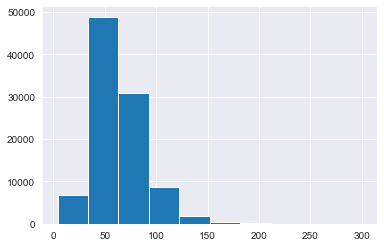

In [84]:
lens.hist()

Anyway: Next is work. We're going to investigate the titles and look for certain groupings -- in this case:

- Business partners
- Bosses
- Colleagues
- Employees

And see if they're more likely to involve asshole situations relative to the is_asshole average.


In [85]:
work_words = ['business partner', 'boss', 'colleague', 'employee', 'staff', 'co-worker', 'business partners',
             'client', 'clients', 'bosses', 'CEO', 'ceo', 'executive', 'executives', 'manager', 'managers',
             'management', 'company', 'coworker', 'coworkers', 'co-workers', 'co worker', 'co workers', 'colleagues',
             'work hours']

bus_isasshole = df[df.title.str.contains('business partner|business partners|client|clients')]['is_asshole'].mean()
boss_isasshole = df[df.title.str.contains('boss|bosses|CEO|executive|ceo|executives|manager|managers|management|company')]['is_asshole'].mean()
coll_isasshole = df[df.title.str.contains('colleague|co-worker|coworker|colleagues|co-workers|coworkers|co worker|co workers')]['is_asshole'].mean()
employee_isasshole = df[df.title.str.contains('employee|staff|work hours')]['is_asshole'].mean()


bus_count = df[df.title.str.contains('business partner|business partners|client|clients')]['is_asshole'].count()
boss_count = df[df.title.str.contains('boss|bosses|CEO|executive|ceo|executives|manager|managers|management|company')]['is_asshole'].count()
coll_count = df[df.title.str.contains('colleague|co-worker|coworker|colleagues|co-workers|coworkers|co worker|co workers')]['is_asshole'].count()
employee_count = df[df.title.str.contains('employee|staff|work hours')]['is_asshole'].count()


In [86]:
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('business partners', bus_isasshole, is_asshole_mean, bus_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('bosses', boss_isasshole, is_asshole_mean, boss_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('colleagues', coll_isasshole, is_asshole_mean, coll_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('employees', employee_isasshole, is_asshole_mean, employee_count))


The likelihood the subject was an asshole if the issue concerned business partners is 0.2222222222222222, versus the general average of 0.2713833157338965, with a sample size of 81.
The likelihood the subject was an asshole if the issue concerned bosses is 0.21862011637572734, versus the general average of 0.2713833157338965, with a sample size of 1203.
The likelihood the subject was an asshole if the issue concerned colleagues is 0.2646657571623465, versus the general average of 0.2713833157338965, with a sample size of 2199.
The likelihood the subject was an asshole if the issue concerned employees is 0.3176178660049628, versus the general average of 0.2713833157338965, with a sample size of 403.


& looking at the body we see:

In [87]:
bus2_isasshole = df[df.body.str.contains('business partner|business partners|client|clients')]['is_asshole'].mean()
boss2_isasshole = df[df.body.str.contains('boss|bosses|CEO|executive|ceo|executives|manager|managers|management|company')]['is_asshole'].mean()
coll2_isasshole = df[df.body.str.contains('colleague|co-worker|coworker|colleagues|co-workers|coworkers|co worker|co workers')]['is_asshole'].mean()
employee2_isasshole = df[df.body.str.contains('employee|staff|work hours')]['is_asshole'].mean()


bus2_count = df[df.body.str.contains('business partner|business partners|client|clients')]['is_asshole'].count()
boss2_count = df[df.body.str.contains('boss|bosses|CEO|executive|ceo|executives|manager|managers|management|company')]['is_asshole'].count()
coll2_count = df[df.body.str.contains('colleague|co-worker|coworker|colleagues|co-workers|coworkers|co worker|co workers')]['is_asshole'].count()
employee2_count = df[df.body.str.contains('employee|staff|work hours')]['is_asshole'].count()


In [88]:
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('business partners', bus2_isasshole, is_asshole_mean, bus2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('bosses', boss2_isasshole, is_asshole_mean, boss2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('colleagues', coll2_isasshole, is_asshole_mean, coll2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('employees', employee2_isasshole, is_asshole_mean, employee2_count))


The likelihood the subject was an asshole if the issue concerned business partners is 0.22151898734177214, versus the general average of 0.2713833157338965, with a sample size of 790.
The likelihood the subject was an asshole if the issue concerned bosses is 0.23991416309012875, versus the general average of 0.2713833157338965, with a sample size of 9320.
The likelihood the subject was an asshole if the issue concerned colleagues is 0.254898157129001, versus the general average of 0.2713833157338965, with a sample size of 5155.
The likelihood the subject was an asshole if the issue concerned employees is 0.25369167158889544, versus the general average of 0.2713833157338965, with a sample size of 3386.


In [89]:
def work(string):
    title_tokens = set([token.lower() for token in string.split()])
    common_tokens = len(title_tokens.intersection(work_words))

    if common_tokens > 0:
        return 1
    else:
        return 0
    
df.title.apply(work)

0        0
1        0
2        0
3        0
5        0
        ..
97623    0
97624    0
97625    0
97626    0
97627    0
Name: title, Length: 97541, dtype: int64

Let's see if looking at the body of the post makes a difference...

In [90]:
def work_body(string):
    body_tokens = set([token.lower() for token in string.split()])
    common_tokens = len(body_tokens.intersection(work_words))

    if common_tokens > 0:
        return 1
    else:
        return 0

df['work_issues'] = df.body.apply(work_body).value_counts()

In [91]:
df['work_issues'].value_counts()

11323.0    1
86218.0    1
Name: work_issues, dtype: int64

So it ~5x'd! Which is good - a sizeable change, all told. Still, we see that work issues are a smaller emphasis on the AITA forum.

And the work mean for is_asshole is:

In [92]:
work_mean = df[df.body.str.contains('business partner|business partners|client|clients|boss|bosses|CEO|executive|ceo|executives|manager|managers|management|company|colleague|co-worker|coworker|colleagues|co-workers|coworkers|co worker|co workersemployee|staff|work hours')]['is_asshole'].mean()

print(work_mean)

0.2494738424533975


So, almost 3% less than the global average - noteworthy! We can see that it's because people are less likely to be considered assholes when the issue relates to their bosses/management (the sample size is much higher in that category versus the others) - an indicator that, similarly to family dynamics, the community is more sympathetic to the speaker if they are not in the position of power (and if the issue is with respect to an individual who has power over them). While I'd like to be sure that the issue being about employees means that the BOSS is posting, this is not necessarily the case.

Last is relationships. We're going to investigate the titles and look for certain groupings -- in this case:

- Romantic partners
- Hookups
- Cheating
- Sex
- Friendships
- Roommates and Neighbors ("Live-ins", to poorly define the term).

And see if they're more likely to involve asshole situations relative to the is_asshole average.


In [93]:
relationship_words = ['boyfriend', 'girlfriend', 'hookup', 'sex', 'love', 'affair', 'slept with', 
                'sleeping with', 'friend', 'friends', 'homies', 'bros', 'besties', 'roommate', 'neighbor', 
                'neighbors', 'roommates', 'gf', 'bf', 'fwb', 'friends with benefits', 'gfs', 'bfs', 'fiancee', 
                'fiancée', 'fiancé', 'fiance', 'spouse', 'bridesmaid', 'bridesmaids', 'flatmate', 'flatmates',
                'housemate', 'housemates']



gfbf_isasshole = df[df.title.str.contains('gf|bf|gfs|bfs|girlfriend|boyfriend|girlfriends|boyfriends')]['is_asshole'].mean()
drama_isasshole = df[df.title.str.contains('hookup|love|best friend|fwb|friends with benefits')]['is_asshole'].mean()
cheating_isasshole = df[df.title.str.contains('cheating|affair|slept|slept with|fucked|best friend|sleeping with')]['is_asshole'].mean()
sex_isasshole = df[df.title.str.contains('sex')]['is_asshole'].mean()
friend_isasshole = df[df.title.str.contains('friend|friends|homies|bros|besties')]['is_asshole'].mean()
livein_isasshole = df[df.title.str.contains('roommate|roommates|neighbor|neighbors|roomate|roomates|flatmate|flatmates|housemate|housemates')]['is_asshole'].mean()
marriage_isasshole = df[df.title.str.contains('wife|spouse|husband|hubby|fiancee|fiancée|fiancé|fiance|spouse|bridesmaid|bridesmaids')]['is_asshole'].mean()

gfbf_count = df[df.title.str.contains('gf|bf|gfs|bfs|girlfriend|boyfriend|girlfriends|boyfriends')]['is_asshole'].count()
drama_count = df[df.title.str.contains('hookup|love|best friend|fwb|friends with benefits')]['is_asshole'].count()
cheating_count = df[df.title.str.contains('cheating|affair|slept|slept with|fucked|best friend|sleeping with')]['is_asshole'].count()
sex_count = df[df.title.str.contains('sex')]['is_asshole'].count()
friend_count = df[df.title.str.contains('friend|friends|homies|bros|besties')]['is_asshole'].count()
livein_count = df[df.title.str.contains('roommate|roommates|neighbor|neighbors|roomate|roomates|flatmate|flatmates|housemate|housemates')]['is_asshole'].count()
marriage_count = df[df.title.str.contains('wife|spouse|husband|hubby|fiancee|fiancée|fiancé|fiance|spouse|bridesmaid|bridesmaids')]['is_asshole'].count()

In [94]:
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('romantic partners', gfbf_isasshole, is_asshole_mean, gfbf_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('general drama', drama_isasshole, is_asshole_mean, drama_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('cheating', cheating_isasshole, is_asshole_mean, cheating_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('sex', sex_isasshole, is_asshole_mean, sex_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('friends', friend_isasshole, is_asshole_mean, friend_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('neighbors and roommates', livein_isasshole, is_asshole_mean, livein_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('marriage', marriage_isasshole, is_asshole_mean, marriage_count))



The likelihood the subject was an asshole if the issue concerned romantic partners is 0.31636297042395384, versus the general average of 0.2713833157338965, with a sample size of 10921.
The likelihood the subject was an asshole if the issue concerned general drama is 0.3025949953660797, versus the general average of 0.2713833157338965, with a sample size of 2158.
The likelihood the subject was an asshole if the issue concerned cheating is 0.31305398871877516, versus the general average of 0.2713833157338965, with a sample size of 2482.
The likelihood the subject was an asshole if the issue concerned sex is 0.33368091762252344, versus the general average of 0.2713833157338965, with a sample size of 959.
The likelihood the subject was an asshole if the issue concerned friends is 0.2881901775498962, versus the general average of 0.2713833157338965, with a sample size of 23599.
The likelihood the subject was an asshole if the issue concerned neighbors and roommates is 0.24153445417949326, 

One final time, let's look at the body of the posts:

In [95]:
gfbf2_isasshole = df[df.body.str.contains('gf|bf|gfs|bfs|girlfriend|boyfriend|girlfriends|boyfriends')]['is_asshole'].mean()
drama2_isasshole = df[df.body.str.contains('hookup|love|best friend|fwb|friends with benefits')]['is_asshole'].mean()
cheating2_isasshole = df[df.body.str.contains('cheating|affair|slept|slept with|fucked|best friend|sleeping with')]['is_asshole'].mean()
sex2_isasshole = df[df.body.str.contains('sex')]['is_asshole'].mean()
friend2_isasshole = df[df.body.str.contains('friend|friends|homies|bros|besties')]['is_asshole'].mean()
livein2_isasshole = df[df.body.str.contains('roommate|roommates|neighbor|neighbors|roomate|roomates|flatmate|flatmates|housemate|housemates')]['is_asshole'].mean()
marriage2_isasshole = df[df.body.str.contains('wife|spouse|husband|hubby|fiancee|fiancée|fiancé|fiance|spouse|bridesmaid|bridesmaids')]['is_asshole'].mean()


gfbf2_count = df[df.body.str.contains('gf|bf|gfs|bfs|girlfriend|boyfriend|girlfriends|boyfriends')]['is_asshole'].count()
drama2_count = df[df.body.str.contains('hookup|love|best friend|fwb|friends with benefits')]['is_asshole'].count()
cheating2_count = df[df.body.str.contains('cheating|affair|slept|slept with|fucked|best friend|sleeping with')]['is_asshole'].count()
sex2_count = df[df.body.str.contains('sex')]['is_asshole'].count()
friend2_count = df[df.body.str.contains('friend|friends|homies|bros|besties')]['is_asshole'].count()
livein2_count = df[df.body.str.contains('roommate|roommates|neighbor|neighbors|roomate|roomates|flatmate|flatmates|housemate|housemates')]['is_asshole'].count()
marriage2_count = df[df.body.str.contains('wife|spouse|husband|hubby|fiancee|fiancée|fiancé|fiance|spouse|bridesmaid|bridesmaids')]['is_asshole'].count()


In [96]:
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('romantic partners', gfbf2_isasshole, is_asshole_mean, gfbf2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('general drama', drama2_isasshole, is_asshole_mean, drama2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('cheating', cheating2_isasshole, is_asshole_mean, cheating2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('sex', sex2_isasshole, is_asshole_mean, sex2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('friends', friend2_isasshole, is_asshole_mean, friend2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('neighbors and roommates', livein2_isasshole, is_asshole_mean, livein2_count))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}, with a sample size of {}.".format('marriage', marriage2_isasshole, is_asshole_mean, marriage2_count))



The likelihood the subject was an asshole if the issue concerned romantic partners is 0.28134302223778673, versus the general average of 0.2713833157338965, with a sample size of 22844.
The likelihood the subject was an asshole if the issue concerned general drama is 0.2626356733591093, versus the general average of 0.2713833157338965, with a sample size of 21467.
The likelihood the subject was an asshole if the issue concerned cheating is 0.2870293657369051, versus the general average of 0.2713833157338965, with a sample size of 10863.
The likelihood the subject was an asshole if the issue concerned sex is 0.30169995048687903, versus the general average of 0.2713833157338965, with a sample size of 6059.
The likelihood the subject was an asshole if the issue concerned friends is 0.2756091472897986, versus the general average of 0.2713833157338965, with a sample size of 52081.
The likelihood the subject was an asshole if the issue concerned neighbors and roommates is 0.25221709826179495

It's fair to assume that a number of posts examined through this analysis are also in other categories (a post can be both about "family" and "relationships" (romantic relations), for example) - still, it's helpful to note the asshole averages here. 

It seems to me that, with respect to the asshole averages, the ones in Title will be more suggestive, even if the sample sizes are smaller, because the title, given its concise nature, signals more clearly what the post is about. So we can see that if the post concerns marriage in Title, the percentage of people designated asshole is a notable 34% -- 7 points higher than average. It reduces to 28% if we look at the body of the post. We see this repeatedly - sex is 33.3% vs 30.1%, cheating is 31.3% vs 28.7%, romantic partners is 31.6% vs 28.1%. (One wonders how these averages would change if we could assess whether the poster is a male vs female, though many times that can only be inferred through the text.)

Looking at outside sources, we see that Reddit tends to skew male: https://social.techjunkie.com/demographics-reddit/ -- possibly to 2/3 male. While it's true that subreddits will have different proportions based on interest, subject, etc., I'd be inclined to believe that most relationship issues on this subreddit are posted by males. Keeping the half-joke in mind that "if a man cheats, it's because he's an asshole, and if a woman cheats, it's because he's an asshole", perhaps there is less tolerance towards men/male behavior in relationships, or perhaps the issues they're posting about are more inflammatory?

Note that friendships roughly meet the global average, whereas roommates and neighbors are below the average. With friendships, there's a roughly equal give-and-take -- the mutuality means that one is just as likely to be on either side of the fence. Why are people posting about their neighbors and roommates less likely to be called assholes? Is there something about the nature or quality of these interactions that the community is more likely to tolerate? Are the issues being posted about often describing a slanted (unfavorable to them) situation, to which they're reacting?

In [97]:
def relationships(string):
    title_tokens = set([token.lower() for token in string.split()])
    common_tokens = len(title_tokens.intersection(relationship_words))

    if common_tokens > 0:
        return 1
    else:
        return 0
    
df.title.apply(relationships)

0        0
1        0
2        0
3        0
5        0
        ..
97623    0
97624    0
97625    0
97626    0
97627    0
Name: title, Length: 97541, dtype: int64

And again, counting it in the body (since relationship issues are visibly mentioned a lot more than other issues:

In [98]:
def relationships_body(string):
    body_tokens = set([token.lower() for token in string.split()])
    common_tokens = len(body_tokens.intersection(relationship_words))

    if common_tokens > 0:
        return 1
    else:
        return 0
    
df['relationship_issues'] = df.body.apply(relationships_body).value_counts()

In [99]:
df['relationship_issues'].value_counts()

38777.0    1
58764.0    1
Name: relationship_issues, dtype: int64

Anecdotally, this feels reflective - about 40% of the issues are about relationships, which makes plenty of sense.

In [100]:
relationship_mean = df[df.body.str.contains('gf|bf|gfs|bfs|girlfriend|boyfriend|girlfriends|boyfriends|hookup|love|best friend|fwb|friends with benefits|cheating|affair|slept|slept with|fucked|best friend|sleeping with|friend|friends|homies|bros|besties|roommate|roommates|neighbor|neighbors|roomate|roomates|flatmate|flatmates|housemate|housemates|wife|spouse|husband|hubby|fiancee|fiancée|fiancé|fiance|spouse|bridesmaid|bridesmaids')]['is_asshole'].mean()

print(relationship_mean)

0.27398360474133154


Looking at the is_asshole mean through title, we see 29.4% - ~2% higher:

In [101]:
relationship_mean_title = df[df.title.str.contains('gf|bf|gfs|bfs|girlfriend|boyfriend|girlfriends|boyfriends|hookup|love|best friend|fwb|friends with benefits|cheating|affair|slept|slept with|fucked|best friend|sleeping with|friend|friends|homies|bros|besties|roommate|roommates|neighbor|neighbors|roomate|roomates|flatmate|flatmates|housemate|housemates|wife|spouse|husband|hubby|fiancee|fiancée|fiancé|fiance|spouse|bridesmaid|bridesmaids')]['is_asshole'].mean()

print(relationship_mean_title)

0.29456584243818285


In [102]:
df['bfgf'] = np.where(df['body'].str.contains('gf|bf|gfs|bfs|girlfriend|boyfriend|girlfriends|boyfriends'), 1, 0)
df['drama'] = np.where(df['body'].str.contains('hookup|love|best friend|fwb|friends with benefits'), 1, 0)
df['cheating'] = np.where(df['body'].str.contains('cheating|affair|slept|slept with|fucked|best friend|sleeping with'), 1, 0)
df['sex'] = np.where(df['body'].str.contains('sex'), 1, 0)
df['friend'] = np.where(df['body'].str.contains('friend|friends|homies|bros|besties'), 1, 0)
df['livein'] = np.where(df['body'].str.contains('roommate|roommates|neighbor|neighbors|roomate|roomates|flatmate|flatmates|housemate|housemates'), 1, 0)
df['marriage'] = np.where(df['body'].str.contains('wife|spouse|husband|hubby|fiancee|fiancée|fiancé|fiance|spouse|bridesmaid|bridesmaids'), 1, 0)
df['bizpartners'] = np.where(df['body'].str.contains('business partner|business partners|client|clients'), 1, 0)
df['bosses'] = np.where(df['body'].str.contains('boss|bosses|CEO|executive|ceo|executives|manager|managers|management|company'), 1, 0)
df['colleagues'] = np.where(df['body'].str.contains('colleague|co-worker|coworker|colleagues|co-workers|coworkers|co worker|co workers'), 1, 0)
df['employees'] = np.where(df['body'].str.contains('employee|staff|work hours'), 1, 0)
df['stepfam'] = np.where(df['body'].str.contains('stepbrother|stepmother|stepfather|stepsister|stepdad'), 1, 0)
df['godfam'] = np.where(df['body'].str.contains('godmother|godfather|godparents|godson|goddaughter|godchild'), 1, 0)
df['grandparents'] = np.where(df['body'].str.contains('grandmother|grandfather|grandpa|grandma|granddad|grandmothers|grandfathers'), 1, 0)
df['parents'] = np.where(df['body'].str.contains('dad|mom|mother|father|mum|daddy'), 1, 0)
df['siblings'] = np.where(df['body'].str.contains('brother|sister|sibling|siblings|brothers|sisters'), 1, 0)
df['kids'] = np.where(df['body'].str.contains('daughter|son|child|kid|stepson|stepdaughter|daughters|sons|kids'), 1, 0)           
df['relatives'] = np.where(df['body'].str.contains('niece|nephew|uncle|aunt|cousin|cousins|nephews'), 1, 0)
df['inlaws'] = np.where(df['body'].str.contains('mil|bil|sil|brother-in-law|sister-in-law|brother in law|sister in law|mother-in-law|mother in law|in-laws|in laws'), 1, 0)



#Regex, possibly
#.split ways to do it
#https://stackoverflow.com/questions/26242494/counting-the-number-of-times-a-word-appears-in-a-string

#for word in string.split - if word in (all words), +1

In [103]:
def getcount(post):

    count_dict = {"relationships" : 0,
                  "family" : 0,
                  "work" : 0}
    
    for word in post.split():
        if word in relationship_words:
            count_dict["relationships"] += 1
        elif word in family_words:
            count_dict["family"] += 1
        elif word in work_words:
            count_dict["work"] += 1

    return count_dict


df.body.apply(getcount)


#total % of words in dict for each 'segment'

0        {'relationships': 0, 'family': 0, 'work': 0}
1        {'relationships': 1, 'family': 0, 'work': 0}
2        {'relationships': 0, 'family': 0, 'work': 0}
3        {'relationships': 0, 'family': 0, 'work': 0}
5        {'relationships': 2, 'family': 0, 'work': 2}
                             ...                     
97623    {'relationships': 1, 'family': 1, 'work': 0}
97624    {'relationships': 1, 'family': 0, 'work': 0}
97625    {'relationships': 0, 'family': 1, 'work': 0}
97626    {'relationships': 0, 'family': 7, 'work': 0}
97627    {'relationships': 0, 'family': 0, 'work': 3}
Name: body, Length: 97541, dtype: object

In [104]:
df.iloc[4]['body']

'I love the musical *Les Miserables*. A coworker of mine said that they didn\'t like it. I asked why and they said, among other things, that "it\'s not a musical, it\'s an opera."\n\nNow, I happen to be an opera singer. I told them adamantly that it is NOT an opera. There are a number of things that make this true, but if you can take my word for it- and I hope you can- it\'s not a matter of opinion whether a mainstream musical is an opera or not. It is a musical, period.\n\nMy coworker thought otherwise. "My boyfriend writes musicals and he agrees with me" was the extent of her argument. Well, he may well write musicals but that doesn\'t mean he knows anything about opera. You might as well ask a jazz pianist to tell you about Beethoven- it\'s not the same area of expertise even if it\'s related. I told her "You\'re entitled to your opinion even if it\'s wrong" in a sort-of joking way. Maybe I was being dickish.\n\nI gotta know- am I the asshole?'

# Hypothesis Six

6) Looking for adjectives that suggest passion/anger/frustration, and if there's a correlation between valence and assholery. 

Null: That there is no relationship between the valence of an adjective used and the likelihood that a post will be categorized as is_asshole.

Theory:
    That words that suggest a higher emotional valence will indicate a *lesser* inclination for assholery. (Example: "AITA for abandoning my depressed friend?") It shows the writer's self-awareness (they're more interested in writing something that gets a lot of attention/is eye-catching, to validate that they're NOT an asshole).


Wordcloud first:

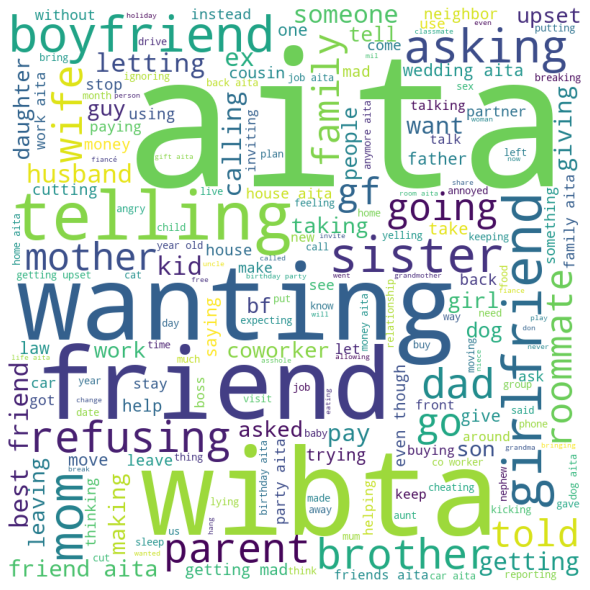

In [105]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [106]:
def make_xy(df, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.title)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.is_asshole.values.astype(np.int)
    return X, y
X, y = make_xy(df)

In [107]:
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed in as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [108]:
_, itest = train_test_split(range(df.shape[0]), train_size=0.7)
mask = np.zeros(df.shape[0], dtype=np.bool) #look this up more - this makes an array of zeros - for those rows 
                                            #in the itest of 1, make it true (so there's a bunch of trues and 
                                            #falses)
mask[itest] = True

In [109]:
best_alpha = 0.05

vectorizer = TfidfVectorizer(tokenizer=None,
               min_df=30, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X, y = make_xy(df, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

#x matrix becomes # of times likely to appear, and y matrix is yes/no

# adding ngram_range=(1, 2) to tfidf vectorizer increases accuracy on training data to 88% but reduces
# accuracy on test data to 68.6% (still higher than count vectorizer).

Accuracy on training data: 0.736151
Accuracy on test data:     0.726354


So we see that evaluating the usage of certain words gives a prediction significantly better than a chance evaluation!

Let's see how things look when we cluster - what does the text coalesce around?

In [110]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    processed = re.sub(r"\d+","",normalized)
    y = processed.split()
    return y

So that said, let's check out what these good + bad words are.

In [111]:
words = np.array(vectorizer.get_feature_names())

x = len(words)

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:1000]]
bad_words = words[ind[-1000:]]

good_prob = probs[ind[:1000]]
bad_prob = probs[ind[-1000:]]

print("Good words\t     P(is_asshole | word)")
for w, p in zip(good_words, good_prob):
    "{:>20}".format(w), "{:.2f}".format(1 - np.exp(p))
    
    #Formerly print in above line, removed so we don't have to see 4,000 words.
    
print("Bad words\t     P(is_asshole | word)")
for w, p in zip(bad_words, bad_prob):
    "{:>20}".format(w), "{:.2f}".format(1 - np.exp(p))

words = np.array(vectorizer.get_feature_names())


Good words	     P(is_asshole | word)
Bad words	     P(is_asshole | word)


In [112]:
probs_dict = {}


for w, p in zip(good_words, good_prob):
    probs_dict[w] = (1 - np.exp(p))
    
for w, p in zip(bad_words, bad_prob):
    probs_dict[w] = (1 - np.exp(p))

words_prob = pd.DataFrame({'words': list(probs_dict.keys()), 'probabilities': list(probs_dict.values())})

#row = df['id'] df['title'], word, value
#index (col) = title, words_in_Title & Prob_is_asshole

#learn to pass index.

In [113]:
#probs_dict.head(10)
#probs_dict.head(-10)
from itertools import islice

def take(n, iterable):
    #Return first n items of the iterable as a list
    return list(islice(iterable, n))

n_items = take(10, probs_dict.items())
print(n_items)

[('chinese', 0.9540145679957512), ('revenge', 0.9040184725564379), ('honking', 0.7558533897487839), ('bet', 0.7180219442732908), ('fish', 0.7146493930063698), ('attitude', 0.7054044161962858), ('basement', 0.6980268542437688), ('unintentionally', 0.6900323248249106), ('match', 0.6879090655973572), ('speech', 0.684258448821828)]


In [114]:
words_prob['parts_of_speech'] = nltk.pos_tag(words_prob['words'])

For reference to what the parts of speech stand for, here's a list:

    CC coordinating conjunction
    CD cardinal digit
    DT determiner
    EX existential there (like: “there is” … think of it like “there exists”)
    FW foreign word
    IN preposition/subordinating conjunction
    JJ adjective ‘big’
    JJR adjective, comparative ‘bigger’
    JJS adjective, superlative ‘biggest’
    LS list marker 1)
    MD modal could, will
    NN noun, singular ‘desk’
    NNS noun plural ‘desks’
    NNP proper noun, singular ‘Harrison’
    NNPS proper noun, plural ‘Americans’
    PDT predeterminer ‘all the kids’
    POS possessive ending parent’s
    PRP personal pronoun I, he, she
    PRP$ possessive pronoun my, his, hers
    RB adverb very, silently,
    RBR adverb, comparative better
    RBS adverb, superlative best
    RP particle give up
    TO, to go ‘to’ the store.
    UH interjection, errrrrrrrm
    VB verb, base form take
    VBD verb, past tense took
    VBG verb, gerund/present participle taking
    VBN verb, past participle taken
    VBP verb, sing. present, non-3d take
    VBZ verb, 3rd person sing. present takes
    WDT wh-determiner which
    WP wh-pronoun who, what
    WP$ possessive wh-pronoun whose
    WRB wh-abverb where, when

In [115]:
words_prob

#Find how many of any specific POS are above/below the is_asshole line.

,words,probabilities,parts_of_speech
0,chinese,0.954015,"(chinese, JJ)"
1,revenge,0.904018,"(revenge, NN)"
2,honking,0.755853,"(honking, VBG)"
3,bet,0.718022,"(bet, JJ)"
4,fish,0.714649,"(fish, JJ)"
...,...,...,...
1995,apparently,0.008173,"(apparently, RB)"
1996,boundaries,0.007015,"(boundaries, VBZ)"
1997,asks,0.006981,"(asks, VBZ)"
1998,alcoholic,0.004693,"(alcoholic, JJ)"


In [116]:
#Test code on str.contains, looking for specific words contained in titles/posts.
mask = df['body'].str.contains(r'std')
df.loc[mask]

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,countI,...,colleagues,employees,stepfam,godfam,grandparents,parents,siblings,kids,relatives,inlaws
5245,9u68zb,2018-11-04 19:26:38,AITA for calling karma on my friend who had TW...,And now he deleted me from his social media be...,True,not the asshole,10,19.0,0,6,...,0,0,0,0,0,0,0,0,0,0
11639,akgl0s,2019-01-27 22:24:24,AITA for ending a 24 year friendship with my b...,\[\n\nI fully realize that anything I post is ...,True,everyone sucks,10,17.0,1,157,...,0,0,0,0,0,1,1,1,0,1
22678,b82ybn,2019-04-01 14:17:19,AITA for how I split up with my FWB?,\n\nSo there is this girl (D) who I have been...,False,asshole,7,68.0,1,31,...,0,0,0,0,0,0,0,1,0,0
22992,b8q7t3,2019-04-02 22:56:36,WIBTA if I refuse to tell the guy Im dating or...,"So I am fairly young, 21, and I have been in ...",False,not the asshole,7,68.0,0,20,...,0,0,0,0,0,0,0,0,0,0
23472,b9mn2g,2019-04-05 04:10:42,AITA for getting upset my mother wants to sell...,Two months ago I had to move home to finish my...,False,asshole,4,10.0,1,21,...,0,0,0,0,0,1,0,1,0,0
29330,bjs6l8,2019-05-02 07:36:03,AITA for using the services of escorts in the ...,"Like my title says, I slept with escorts in th...",False,not the asshole,10,78.0,0,31,...,0,0,0,0,0,0,0,0,0,0
31356,bnpuht,2019-05-12 15:00:21,AITA For Not Shaving?,"My birthday is coming up, so I went out with a...",False,no assholes here,176,124.0,0,14,...,1,0,0,0,0,0,0,1,0,0
34792,bu8g6z,2019-05-29 01:25:27,AITA for breaking up with my gf for having and...,So my girlfriend (22) and I (24) have been dat...,True,asshole,13,53.0,1,31,...,0,0,0,0,0,0,0,0,0,0
41201,c5jcwd,2019-06-26 01:59:17,aita about hsv-1?,aita for not wanting to get serious with someo...,False,no assholes here,7,15.0,0,7,...,0,0,0,0,0,0,0,0,0,0
52583,cma42m,2019-08-05 12:03:41,WIBTA if i tell my ex's mother about him cheat...,Throwaway cuz he knows my real acc. We're both...,True,everyone sucks,4,15.0,1,14,...,0,0,0,0,0,1,0,1,0,1


For future work: We can groupby verbs, nouns, and adjectives, to see if there are any interesting patterns that stick out.

In [117]:
sid = SentimentIntensityAnalyzer()

def sidscore(title):
    
    isasshole_valence = []
    
    for i in title:
        isasshole_valence.append(sid.polarity_scores(i))
                             
    return isasshole_valence

In [118]:
new_var = sidscore(df['title'])
new_var = pd.DataFrame(new_var)

In [119]:
df = pd.concat([df, new_var], axis=1)

In [120]:
df.head()

#group by increasing neg, and see if is_asshole is more likely at the upper quartile vs lower quartile of neg.

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,countI,...,grandparents,parents,siblings,kids,relatives,inlaws,neg,neu,pos,compound
0,1ytxov,2014-02-24 21:50:51,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52.0,13.0,1.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.000,0.000,0.0000
1,1yu29c,2014-02-24 22:33:04,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",True,asshole,140.0,27.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.000,0.000,0.0000
2,1yu8hi,2014-02-24 23:31:17,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74.0,15.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.706,0.294,0.3612
3,1yuc78,2014-02-25 00:05:28,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,True,everyone sucks,22.0,3.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.263,0.737,0.000,-0.3612
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.263,0.737,0.000,-0.3612


Text(0.5, 1.0, 'neg')

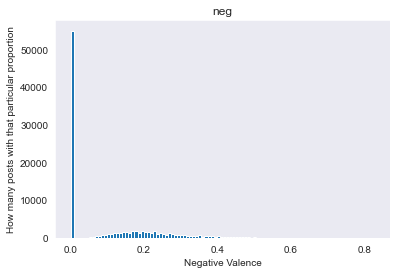

In [121]:
#Notice the huge amount of zeros, i.e. more than half are largely assessed as positive valence. Let's zoom in.

plt.hist(df['neg'], bins=100);
plt.xlabel('Negative Valence')
plt.ylabel('How many posts with that particular proportion')
plt.title('neg')

Text(0.5, 1.0, 'neg')

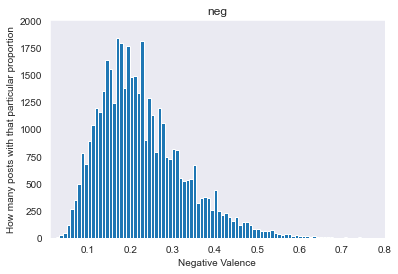

In [122]:
#Most neg, adding up to ~40,000

plt.hist(df['neg'], bins=100);
plt.xlim(0.01, 0.8)
plt.ylim(0, 2000)
plt.xlabel('Negative Valence')
plt.ylabel('How many posts with that particular proportion')
plt.title('neg')

In [123]:
neg_quantilelow = df['neg'].quantile(q=0.2)
neg_quantilehigh = df['neg'].quantile(q=0.8)

df['neg_highQ'] = df['neg'].apply(lambda x: x > neg_quantilehigh)
df['neg_lowQ'] = df['neg'].apply(lambda x: x > neg_quantilelow)

In [124]:
negH_mean1, negH_mean2 = df.groupby('neg_highQ')['is_asshole'].mean()
negL_mean1, negL_mean2 = df.groupby('neg_lowQ')['is_asshole'].mean()

In [125]:
print(negH_mean1, negH_mean2)
print(negL_mean1, negL_mean2)

0.27138926217444165 0.2713593733896733
0.27041966688486435 0.2726289810788577


In [126]:
neg_HQ_isasshole = df.loc[df.is_asshole == 1, 'neg_highQ']
neg_HQ_notasshole = df.loc[df.is_asshole == 0, 'neg_highQ']

neg_LQ_isasshole = df.loc[df.is_asshole == 1, 'neg_lowQ']
neg_LQ_notasshole = df.loc[df.is_asshole == 0, 'neg_lowQ']


In [127]:
print(ttest_ind(neg_HQ_isasshole, neg_HQ_notasshole))

print(ttest_ind(neg_LQ_isasshole, neg_LQ_notasshole))

#No signifcance indicated here, esp. as compared to our other features.

Ttest_indResult(statistic=-0.008380306393523876, pvalue=0.99331357831679)
Ttest_indResult(statistic=0.7695014353544162, pvalue=0.4415975561801805)


Text(0.5, 1.0, 'pos')

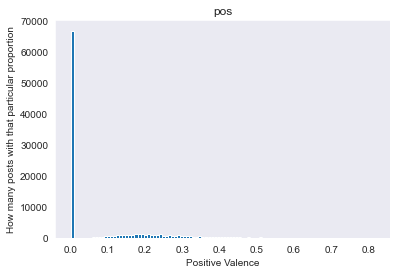

In [128]:
#Notice the huge amount of zeros, i.e. almost 70000 are not positive valence. Let's zoom in.

plt.hist(df['pos'], bins=100);
plt.xlabel('Positive Valence')
plt.ylabel('How many posts with that particular proportion')
plt.title('pos')

Text(0.5, 1.0, 'neg')

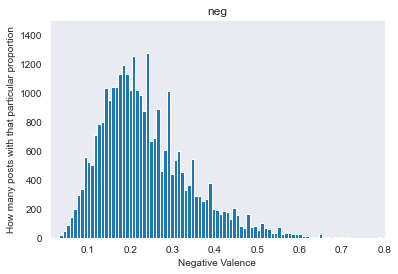

In [129]:
#Most neg, adding up to ~25,000

plt.hist(df['pos'], bins=100);
plt.xlim(0.01, 0.8)
plt.ylim(0, 1500)
plt.xlabel('Negative Valence')
plt.ylabel('How many posts with that particular proportion')
plt.title('neg')

In [130]:
pos_quantilelow = df['pos'].quantile(q=0.2)
pos_quantilehigh = df['pos'].quantile(q=0.8)

df['pos_highQ'] = df['pos'].apply(lambda x: x > pos_quantilehigh)
df['pos_lowQ'] = df['pos'].apply(lambda x: x > pos_quantilelow)

In [131]:
posH_mean1, posH_mean2 = df.groupby('pos_highQ')['is_asshole'].mean()
posL_mean1, posL_mean2 = df.groupby('pos_lowQ')['is_asshole'].mean()

In [132]:
print(posH_mean1, posH_mean2)
print(posL_mean1, posL_mean2)



0.2713307090639538 0.2715966212364616
0.27072252435307476 0.27282825312816494


In [133]:
pos_HQ_isasshole = df.loc[df.is_asshole == 1, 'pos_highQ']
pos_HQ_notasshole = df.loc[df.is_asshole == 0, 'pos_highQ']

pos_LQ_isasshole = df.loc[df.is_asshole == 1, 'pos_lowQ']
pos_LQ_notasshole = df.loc[df.is_asshole == 0, 'pos_lowQ']


In [134]:
print(ttest_ind(pos_HQ_isasshole, pos_HQ_notasshole))

print(ttest_ind(pos_LQ_isasshole, pos_LQ_notasshole))

#No signifcance indicated here, esp. as compared to our other features.

Ttest_indResult(statistic=0.07439940610989329, pvalue=0.9406927339198379)
Ttest_indResult(statistic=0.6862869961912869, pvalue=0.49253377880798055)


And, finally, let's groupby negative, to see if valence in the title leads to a greater likelihood of being an asshole:

& by compound:

(We can delete the "neutral" column, since we're not very interested in neutrality.)

Text(0.5, 1.0, 'Compound')

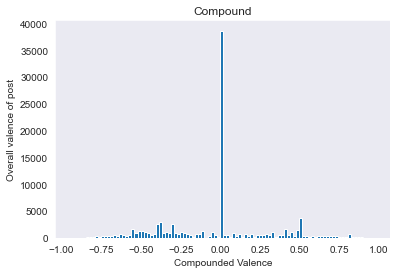

In [135]:
#Most posts are revealed to have a neutral valence (0), adding up to < 40,000

plt.hist(df['compound'], bins=100);
plt.xlabel('Compounded Valence')
plt.ylabel('Overall valence of post')
plt.title('Compound')

Text(0.5, 1.0, 'Overall valence of posts, negative tail')

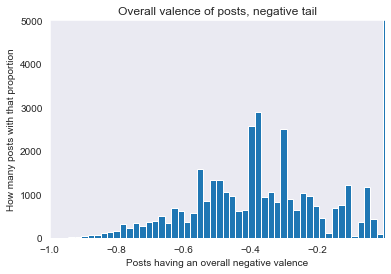

In [136]:
#Interesting that this is manifested differently from the standard curve we saw with "neg" earlier.

plt.hist(df['compound'], bins=100);
plt.xlim(-1, -0.001)
plt.ylim(0, 5000)
plt.xlabel('Posts having an overall negative valence')
plt.ylabel('How many posts with that proportion')
plt.title('Overall valence of posts, negative tail')

Text(0.5, 1.0, 'Overall valence of posts, positive tail')

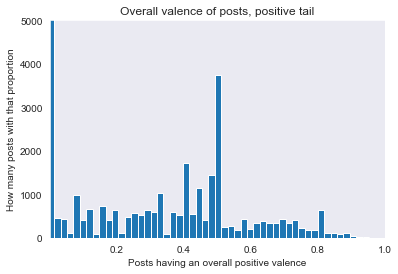

In [137]:
#Notice the huge amount of zeros, i.e. more than half are largely assessed as positive valence. Let's zoom in.

plt.hist(df['compound'], bins=100);
plt.xlim(0.001, 1)
plt.ylim(0, 5000)
plt.xlabel('Posts having an overall positive valence')
plt.ylabel('How many posts with that proportion')
plt.title('Overall valence of posts, positive tail')

Curious to see the spikes at the 0.5 and -0.4 space. Warrants further investigation.

In [138]:
compound_quantilelow = df['compound'].quantile(q=0.2)
compound_quantilehigh = df['compound'].quantile(q=0.8)

df['compound_highQ'] = df['compound'].apply(lambda x: x > compound_quantilehigh)
df['compound_lowQ'] = df['compound'].apply(lambda x: x > compound_quantilelow)

In [139]:
compoundH_mean1, compoundH_mean2 = df.groupby('compound_highQ')['is_asshole'].mean()
compoundL_mean1, compoundL_mean2 = df.groupby('compound_lowQ')['is_asshole'].mean()

In [140]:
print(compoundH_mean1, compoundH_mean2)
print(compoundL_mean1, compoundL_mean2)

0.2707620409622555 0.27391417425227566
0.26943593796305443 0.27189339543308105


In [141]:
compound_HQ_isasshole = df.loc[df.is_asshole == 1, 'compound_highQ']
compound_HQ_notasshole = df.loc[df.is_asshole == 0, 'compound_highQ']

compound_LQ_isasshole = df.loc[df.is_asshole == 1, 'compound_lowQ']
compound_LQ_notasshole = df.loc[df.is_asshole == 0, 'compound_lowQ']


In [142]:
print(ttest_ind(compound_HQ_isasshole, compound_HQ_notasshole))

print(ttest_ind(compound_LQ_isasshole, compound_LQ_notasshole))

#No signifcance indicated here, esp. as compared to our other features.

Ttest_indResult(statistic=0.880695021056485, pvalue=0.3784850823383167)
Ttest_indResult(statistic=0.6999922568042284, pvalue=0.48393380961153787)


Fascinating - valence in the title has no relationship with whether or not someone is an asshole.

Then some final cleanup:

In [143]:
df.columns

Index(['id', 'timestamp', 'title', 'body', 'edited', 'verdict', 'score',
       'num_comments', 'is_asshole', 'countI', 'countHeSheThey',
       'IvsHeSheThey', 'post_word_count', 'questionmarklast', 'WIBTA_AITA',
       'bodyreadinglevel', 'countI_highQ', 'countI_lowQ',
       'countHeSheThey_highQ', 'countHeSheThey_lowQ', 'IvsHeSheThey_highQ',
       'IvsHeSheThey_lowQ', 'post_word_count_highQ', 'post_word_count_lowQ',
       'IoverPostCount', 'IoverPostCount_highQ', 'IoverPostCount_lowQ',
       'bodyreadinglevel_highQ', 'bodyreadinglevel_lowQ', 'family_issues',
       'work_issues', 'relationship_issues', 'bfgf', 'drama', 'cheating',
       'sex', 'friend', 'livein', 'marriage', 'bizpartners', 'bosses',
       'colleagues', 'employees', 'stepfam', 'godfam', 'grandparents',
       'parents', 'siblings', 'kids', 'relatives', 'inlaws', 'neg', 'neu',
       'pos', 'compound', 'neg_highQ', 'neg_lowQ', 'pos_highQ', 'pos_lowQ',
       'compound_highQ', 'compound_lowQ'],
      dtype='objec

And we're ready for our modeling! We're going to evaluate our results using recall rather than accuracy - the goal is to figure out how many of our assessments of is_asshole are correct relative to all of the assholes in the dataset. I'm trying out Decision Trees and Random Forests, just to see how they do.

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree, metrics

In [153]:
Prediction = df.dropna()

In [154]:
features = ['edited', 'countI', 'countHeSheThey', 'IvsHeSheThey', 'post_word_count', 'questionmarklast', 
            'WIBTA_AITA', 'bodyreadinglevel', 'countI_highQ', 'countI_lowQ', 'countHeSheThey_highQ', 
            'countHeSheThey_lowQ', 'IvsHeSheThey_highQ', 'IvsHeSheThey_lowQ', 'post_word_count_highQ', 
            'post_word_count_lowQ', 'IoverPostCount', 'IoverPostCount_highQ', 'IoverPostCount_lowQ',
            'bodyreadinglevel_highQ', 'bodyreadinglevel_lowQ', 'family_issues',
            'work_issues', 'relationship_issues', 'bfgf', 'drama', 'cheating', 'sex', 'friend', 'livein', 
            'marriage', 'bizpartners', 'bosses', 'colleagues', 'employees', 'stepfam', 'godfam', 'grandparents',
            'parents', 'siblings', 'kids', 'relatives', 'inlaws', 'neg', 'neu', 'pos', 'compound', 'neg_highQ', 
            'neg_lowQ', 'pos_highQ', 'pos_lowQ', 'compound_highQ', 'compound_lowQ']

X = Prediction[features] 
y = Prediction.is_asshole

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 246)

In [156]:
X_train = pd.get_dummies(X_train)

X_test = pd.get_dummies(X_test)

In [157]:
# Declare a variable called entr_model and use tree.DecisionTreeClassifier. 
df_dectree = tree.DecisionTreeClassifier(criterion="entropy", random_state = 1234, max_depth = 3)

# Call fit() on entr_model
df_dectree.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = df_dectree.predict(X_test)

# Call Series on our y_pred variable with the following: pd.Series(y_pred)
pd.Series(y_pred)

# Check out entr_model
df_dectree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [165]:
# Run this block for model evaluation metrics 
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Precision score for "No"' , metrics.precision_score(y_test,y_pred, pos_label = "NO"))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_pred, pos_label = "YES"))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Model Entropy - no max depth
Accuracy: 1.0
Balanced accuracy: 1.0


ValueError: y contains previously unseen labels: [1.0]

In [ ]:
# Plug in appropriate max_depth and random_state parameters 
firstRFModel = RandomForestClassifier(max_depth=3, random_state=1234)

firstRFModel.fit(X_train, y_train)

y_pred = firstRFModel.predict(X_test)

pd.Series(y_pred)

In [ ]:
firstRFModel

print("Random Forest model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

In [144]:
#XGBoost. 
 #Can do .fit / predict in scikit.learn as well.